In [1]:
import os 
import glob
import json
import numpy as np
import pandas as pd
import SimpleITK as sitk
import psycopg2
import matplotlib.pyplot as plt
from numpy.linalg import inv
import requests
import shutil
%matplotlib inline



CONNECTION_STRING = 'host=limsdb2 dbname=lims2 user=limsreader password=limsro'
IMAGE_SERVICE_STRING = 'http://lims2/cgi-bin/imageservice'

def query(sql, args):
    conn = psycopg2.connect(CONNECTION_STRING)
    cur = conn.cursor()

    cur.execute(sql, args)
    results = cur.fetchall()

    cur.close()
    conn.close()

    return results

In [2]:
def visualize_landmarks( image_2d, landmarks = [] ) :
    
    # visualize a 2D image with landmarks superimposed

    left = (-0.5) * image_2d.GetSpacing()[0]
    right = (image_2d.GetSize()[0] - 0.5) * image_2d.GetSpacing()[0]
    bottom = (image_2d.GetSize()[1] - 0.5) * image_2d.GetSpacing()[1]
    top =  (- 0.5) * image_2d.GetSpacing()[1]

    slice = sitk.GetArrayViewFromImage(image_2d)
    plt.imshow(slice, extent = (left,right,bottom,top))
    
    for p in landmarks :
        print(p)
        plt.plot(p[0],p[1],'r+',markersize=10)

In [3]:
def flatten( lm ) :
    
    # flatten a set of points as input to SimpleITK landmark based registration
    
    return [ c for p in lm for c in p]

In [4]:
def initialize_transform( transform_info ) :
    
    # initialize a SimpltITK 3D affine transform from json blob
    arr = np.array( transform_info )
    lut = [0, 1, 2, 4, 5, 6, 8, 9, 10, 3, 7, 11]
    parameters = arr[lut]

    m = np.reshape(parameters[0:9],(3,3))
    t = np.reshape(parameters[9:12],(3,1))
    
    # flip from RAS to LPS  
    # because pinning tool is in RAS but ITK does transforms in LPS
    x = [-1,0,0,0,-1,0,0,0,1]
    x = np.reshape(x,(3,3))
    m = np.matmul(x,m)
    t = np.matmul(x,t)
    
    # flip both axes of the virtual view and move to center
    vm = np.reshape([1,0,0,0,-1,0,0,0,1],(3,3)) #TODO only flipping one axis... why
    vt = np.reshape([-6250,-6250,0],(3,1))
    m = np.matmul(m,vm)
    t = np.add(np.matmul(m,vt),t) 

    affine = sitk.AffineTransform(3)
    affine.SetMatrix(m.flat[:])
    affine.SetTranslation(t.flat[:])
    
    return affine


In [5]:
#
#
# == read in CCF (with fixed headers)
#
#
# image_directory = r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\subcortical\standardization\inputs\average_template'
image_directory =  r'\\allen\programs\celltypes\workgroups\mousecelltypes\_UPENN_fMOST\mouse_ccf_fixed_headers_um\average_template'
ccf_file = os.path.join(image_directory, "average_template_10.nii.gz" )
ccf = sitk.ReadImage( ccf_file )

In [6]:

def get_ccf_coord(specimen_id):
    sql = """
        select x, y, z from cell_soma_locations
        where specimen_id = {}
        """.format(specimen_id)
    x,y,z = query(sql,())[0]
    return x,y,z


from pandas import DataFrame, Series

def query_lims_for_layers(specimen_id):
    sql = """
    SELECT sp.id as specimen_id, sp.name AS specimen, sp.cell_depth,
        imt.name AS image_type, agl.name AS drawing_layer, polygon.id AS polygon_id,
        bp.biospecimen_id,
        polygon.path, layer.mag, polygon.display_attributes, sc.resolution, struct.acronym
    FROM specimens sp JOIN specimens spp ON spp.id=sp.parent_id
    JOIN image_series iser ON iser.specimen_id=spp.id AND iser.type = 'FocalPlaneImageSeries' AND iser.is_stack = 'f'
    JOIN sub_images si ON si.image_series_id=iser.id
    JOIN avg_graphic_objects layer ON layer.sub_image_id=si.id
    JOIN avg_graphic_objects polygon ON polygon.parent_id=layer.id
    LEFT JOIN biospecimen_polygons bp ON polygon.id = bp.polygon_id
    JOIN images im ON im.id=si.image_id
    JOIN image_types imt ON imt.id=im.image_type_id
    JOIN scans sc ON sc.slide_id=im.slide_id
    LEFT JOIN structures struct ON struct.id = polygon.cortex_layer_id
    JOIN avg_group_labels agl ON layer.group_label_id=agl.id
    WHERE sp.id = %s
    ORDER BY 1, 4, 5, 6
    """

    results = query(sql, (specimen_id, ))
    df = DataFrame(results, columns=["specimen_id", "specimen_name", "cell_depth",
                                         "img_type", "draw_type", "poly_id", "biospecimen_id", "poly_coords",
                                         "mag", "dispattr", "res", "layer_acronym"]).drop_duplicates(subset="poly_coords")

#     keep only draw types we are interested in
    used_draw_types = ["Pia", "White Matter", "Soma", "Cortical Layers"]
    df = df.loc[df["draw_type"].isin(used_draw_types), :].drop_duplicates(subset=["biospecimen_id", "poly_coords"])
    
#     keep soma, pia, and wm for specimen only
    mask_out = df["draw_type"].isin(["Pia", "White Matter", "Soma"]).values & (df["biospecimen_id"].values != int(specimen_id))
    df = df.loc[~mask_out, :]

    return df

def get_20x_info(sp_name):
    sql = """
    SELECT  slice.name, subimg.id, subimg.width, subimg.height, sc.resolution,  img.treatment_id
    FROM specimens slice 
    JOIN image_series iser on iser.specimen_id = slice.id -- image series is associated with the slice
    JOIN sub_images subimg on subimg.image_series_id = iser.id -- there are two subimages in the imageseries
    JOIN images img on subimg.image_id = img.id -- each subimage belongs to an image
    JOIN scans sc on sc.image_id = img.id -- an image is output of a scan
    WHERE slice.name = '{}' AND img.treatment_id = 300080909
    """.format(specimen_name)

    x = query(sql, ())[0]
    return x
    

def get_20x_img(sub_image):
    sql ="""
    SELECT sd.storage_directory, img.zoom FROM slides sd
    JOIN images img ON img.slide_id = sd.id
    JOIN sub_images si ON si.image_id = img.id 
    WHERE si.id = '{}'
    """.format(sub_image)
    
    result = query(sql, ())[0]
    sd = result[0]
    aff = result[1]
    aff_path = os.path.join(sd, aff)

    print('result: {}'.format(result))
    print('sd: {}'.format(sd))
    print('aff: {}'.format(aff))
    print('aff_path: {}'.format(aff_path))


    image_path = os.path.join(working_directory, '{}_overview.jpg'.format(specimen_name))
    downsample = 0
    quality = 100
    url = r'{0}?path={1}&'\
                   'downsample={2}&'\
                   'quality={3}'.format(IMAGE_SERVICE_STRING, 
                                        aff_path, downsample, quality)
    
    print('image_path: {}'.format(image_path))
    print('url: {}'.format(url))


    response = requests.get(url, stream=True)
    print('response.raw: {}'.format(response.raw))


    with open(image_path, 'wb') as image_file:
        shutil.copyfileobj(response.raw, image_file)
    del response
    
    
def get_name_by_id(sp_id):
    sql = """
    SELECT sp.name as sp, sp.id
    FROM specimens sp
    WHERE sp.id = '{}'
    """.format(sp_id)
    
    x = query(sql, ())[0][0]
    return x

def get_id_by_name(sp_name):
    sql = """
    SELECT sp.name as sp, sp.id
    FROM specimens sp
    WHERE sp.name = '{}'
    """.format(sp_name)
    
    x = query(sql, ())[0][1]
    return x

def get_pinning_old(sp_name): #how it was in this code. 
    sql = """
    SELECT sp.name AS sp, sm.id, sm.specimen_id, sm.updated_at ,sm.data
    FROM
    specimens sp
    JOIN specimen_metadata sm ON sm.specimen_id=sp.id
    WHERE
    sp.name = '{}' AND
    current = 't' AND kind = 'IVSCC cell locations'
    ORDER BY sm.id DESC;""".format(sp_name)
    
    x = query(sql, ())[0]
    return x

#kind = 'IVSCC cell locations' : the ephys rig person did a rough pinning of location 
#kind = 'IVSCC tissue review' : someone on our team reviewed the rough pinning and validated it. <USE THIS ONE ONLY> in code!

def get_pinning(sp_name): #how it should be in this code (SWB)
    sql = """
    SELECT sp.name AS sp, sm.id, sm.specimen_id, sm.updated_at ,sm.data
    FROM
    specimens sp
    JOIN specimen_metadata sm ON sm.specimen_id=sp.id
    WHERE
    sp.name = '{}' AND
    sm.current = 't' AND sm.kind = 'IVSCC tissue review' 
    ORDER BY sm.id DESC;""".format(sp_name)

    #   'IVSCC cell locations'
    
    x = query(sql, ())[0]
    return x

def get_children(spec_id):
    sql = """
        SELECT sp.id as specimen_id, sp.name AS specimen
        FROM specimens sp JOIN specimens spp ON spp.id=sp.parent_id
        WHERE sp.parent_id = {}
        """.format(spec_id)

    results = query(sql, ())
    children = []
    for r in results:
        if len(r[1].split('.')) > 3:
            print(r)
            children.append(list(r))
            
            
    return children

def get_soma_polygons(spec_id):

    children = get_children(spec_id)
    df = pd.DataFrame()
    for c in children:
        spec = c[0]
        this_cell = query_lims_for_layers(str(spec))
        df = pd.concat([df, this_cell])

    return df
    

In [7]:
def compute_center_from_polyline (aa) :
    aa = aa.split(',')
    aa = [int(x) for x in aa]
    aa = np.reshape(aa,(int(len(aa)/2),2))
    return np.mean( aa , axis = 0)

def get_landmark_ids(spec_id):
    sql = """
        SELECT sp.id as specimen_id, sp.name AS specimen
        FROM specimens sp JOIN specimens spp ON spp.id=sp.parent_id
        WHERE sp.parent_id = {}
        """.format(spec_id)

    results = query(sql, ())
    children = []
    for r in results:
        if len(r[1].split('.')) == 3:
#             print(r)
            children.append(list(r))
    
    return children

def get_landmark_location(spec_id):
    sql = """
        SELECT sp.id as specimen_id, sp.name AS specimen, sp.cell_depth,
            imt.name AS image_type, agl.name AS drawing_layer, polygon.id AS polygon_id,
            bp.biospecimen_id,
            polygon.path, layer.mag, polygon.display_attributes, sc.resolution, struct.acronym
        FROM specimens sp JOIN specimens spp ON spp.id=sp.parent_id
        JOIN image_series iser ON iser.specimen_id=spp.id AND iser.type = 'FocalPlaneImageSeries' AND iser.is_stack = 'f'
        JOIN sub_images si ON si.image_series_id=iser.id
        JOIN avg_graphic_objects layer ON layer.sub_image_id=si.id
        JOIN avg_graphic_objects polygon ON polygon.parent_id=layer.id
        LEFT JOIN biospecimen_polygons bp ON polygon.id = bp.polygon_id
        JOIN images im ON im.id=si.image_id
        JOIN image_types imt ON imt.id=im.image_type_id
        JOIN scans sc ON sc.slide_id=im.slide_id
        LEFT JOIN structures struct ON struct.id = polygon.cortex_layer_id
        JOIN avg_group_labels agl ON layer.group_label_id=agl.id
        WHERE sp.id = '%s' AND agl.name = 'Fiducial' AND bp.biospecimen_id = %s
        """

    results = query(sql, (spec_id, spec_id))


    d = pd.DataFrame(results, columns = ['specimen_id', 'specimen_name', 'cell_depth', 'img_type', 'draw_type',
       'poly_id', 'biospecimen_id', 'poly_coords', 'mag', 'dispattr', 'res','layer_acronym'])
    d.drop_duplicates(subset = 'poly_coords', inplace = True)
    return d
            

In [8]:
#
#  == processing a slide specimen
#  == gather all of the information that you need
#
#out = r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\subcortical\standardization'
# out = r'/Users/sarah.wallingbell/SarahWB/slice_reg/subcortical/standardization'
out = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\ccf_slice_registration\standardization'



# specimen_name = 'Sst-IRES-Cre;Ai14-594119.11.02' # --> coronal - autotrace 
# specimen_name = 'Slc32a1-IRES-Cre;Ai14-562359.09.09' # --> coronal - bad (SAME AS BELOW) <has reoriented+shifted>
# specimen_name = 'C57BL6J-588656.06.04' # --> coronal - bad (SAME AS BELOW) <has reoriented + shifted>
# specimen_name = 'Nos1-CreERT2;Sst-IRES-FlpO;Ai65-553472.08.06' # --> sagittal - good <only reoriented>

#cells from RD where slice reg is wrong 
# specimen_name = 'Slc32a1-IRES-Cre;Ai14-562359.09.09' #.01' # --> coronal - bad     #ex from RD - wasn't pinned, Grace pinned this #pinning now found 
# specimen_name = 'C57BL6J-588656.06.04' #.01'  # --> coronal - bad    
# specimen_name = 'Sst-IRES-Cre;Ai14-554002.07.06' #.01'  # --> sagittal - good   found <only reoriented>

# specimen_name = 'Ctgf-T2A-dgCre;Ai14-553529.08.06'
# specimen_name = 'Sst-IRES-Cre;Ai14-594119.11.02'

# specimen_name = 'C57BL6J-581850.06.03'
specimen_name = 'Pvalb-IRES-Cre;Ai14-553660.05.06'


working_directory = os.path.join(out, specimen_name)

if not os.path.exists(working_directory):
    os.mkdir(working_directory)
specimen_id = get_id_by_name(specimen_name)
# print(specimen_id)

In [9]:
#
# == read in pinning tool output - virtual slice definition and cell ccf locations
#
# file = os.path.join(working_directory,'cell_locator.json')
# with open(file) as j:
#     pinning_info = json.load(j)

pinning_info = get_pinning(specimen_name)[4]
print(len(pinning_info))
# for ix, part in enumerate(pinning_info):
#     print(ix, part)
# pinning_info

pinning_info

8


{'markups': [{'name': 'Pvalb-IRES-Cre;Ai14-553660.05.06.01',
   'markup': {'type': 'Fiducial',
    'controlPoints': [{'id': '1',
      'position': [-8261.5, 6220.57421875, -4290.93017578125],
      'structure': {'id': 1022, 'acronym': 'GPe'},
      'orientation': [-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0]}],
    'coordinateSystem': 'LPS'},
   'orientation': [0.0,
    0.0,
    -1.0,
    8261.5,
    -1.0,
    0.0,
    0.0,
    -6574.999999999999,
    0.0,
    1.0,
    0.0,
    -3987.4999999999995,
    0.0,
    0.0,
    0.0,
    1.0]},
  {'name': 'Pvalb-IRES-Cre;Ai14-553660.05.06.02',
   'markup': {'type': 'Fiducial',
    'controlPoints': [{'id': '1',
      'position': [-8261.5, 6419.460536805739, -4270.5308264682435],
      'structure': {'id': 1022, 'acronym': 'GPe'},
      'orientation': [-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0]}],
    'coordinateSystem': 'LPS'},
   'orientation': [0.0,
    0.0,
    -1.0,
    8261.5,
    -1.0,
    0.0,
    0.0,
    -6574.999999999999,
    0.0

In [10]:
#
# virtual_slice_to_ccf_transform :
#    - transform a 3D point (in micron) in the virtual slice to ccf (in micron)
#
# ccf_to_virtual_slice_transform:
#     - transform a 3D point in ccf (in micron) to virtual slice (in micron)
#
# Each point can have its own orientation - we are taking the first one only #TODO is this an issue? (swb)
#
virtual_slice_to_ccf_transform = initialize_transform( pinning_info['markups'][0]['orientation'] )
ccf_to_virtual_slice_transform = virtual_slice_to_ccf_transform.GetInverse()

#
# == write out the virtual_slice_to_ccf_transform
#
file = os.path.join(working_directory, 'virtual_slice_to_ccf_transform.txt')
sitk.WriteTransform( virtual_slice_to_ccf_transform, file )
# print(file)

In [11]:
#
# == Construct ccf-to-virtual-slice transform and its inverse from the pinning_info
#

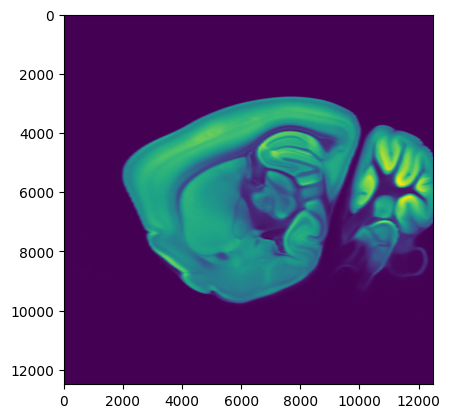

In [13]:
#
# ==  generate a virtual slice from the transforms
#
# virtual_slice_3d is a 3D volume with a single z slice
# virtual_slice    is a 2D volume created by extracting out the single slice
#
virtual_slice_size = [1250,1250,1] # 3D volume with one slice
virtual_slice_size = [1250,1250,1] # 3D volume with one slice

virtual_slice_spacing = ccf.GetSpacing()

virtual_slice_3d = sitk.Resample(ccf, 
                                 virtual_slice_size, 
                                 virtual_slice_to_ccf_transform, 
                                 sitk.sitkLinear,
                                 [0,0,0], 
                                 virtual_slice_spacing, 
                                 [1,0,0,0,1,0,0,0,1], 
                                 0.0, 
                                 ccf.GetPixelID())#, False )


virtual_slice = virtual_slice_3d[:,:,0] # 2D image version
visualize_landmarks( virtual_slice )

#
# == write the 2D virtual slice to file
#
# file = os.path.join(working_directory,'virtual_slice.nii.gz')
# sitk.WriteImage( virtual_slice, file, True )

In [14]:
img_info = [list(get_20x_info(specimen_name))]
img_info

[['Pvalb-IRES-Cre;Ai14-553660.05.06',
  1067555916,
  26009,
  18635,
  0.3603,
  300080909]]

result: ('/allen/programs/celltypes/production/mousecelltypes/prod2956/0500413344_1067555913/', '0500413344_300080909.aff')
sd: /allen/programs/celltypes/production/mousecelltypes/prod2956/0500413344_1067555913/
aff: 0500413344_300080909.aff
aff_path: /allen/programs/celltypes/production/mousecelltypes/prod2956/0500413344_1067555913/0500413344_300080909.aff
image_path: \\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\ccf_slice_registration\standardization\Pvalb-IRES-Cre;Ai14-553660.05.06\Pvalb-IRES-Cre;Ai14-553660.05.06_overview.jpg
url: http://lims2/cgi-bin/imageservice?path=/allen/programs/celltypes/production/mousecelltypes/prod2956/0500413344_1067555913/0500413344_300080909.aff&downsample=0&quality=100
response.raw: <urllib3.response.HTTPResponse object at 0x000001FD61DBE580>


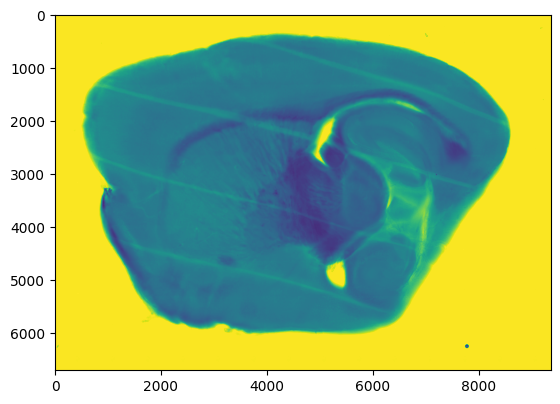

In [15]:
#
# == read in the 2D overview image and associate metadata
#
# img_info = [list(get_20x_info(specimen_name))]
img_info = [list(get_20x_info(specimen_name))]


odf = pd.DataFrame(img_info, columns = ['specimen_name', 'sub_image_id', 'width', 'height', 'resolution', 'treatment_id'])

overview_info = odf.loc[0]

sub_image = odf['sub_image_id'].values[0]
get_20x_img(sub_image)   
file = os.path.join(working_directory, '{}_overview.jpg'.format(specimen_name))
overview = sitk.ReadImage( file )
overview_spacing = [overview_info['resolution'],overview_info['resolution']]
overview.SetSpacing(overview_spacing)

#
# == downsample the 2D overview image
#
downsampled_overview = sitk.BinShrink( sitk.VectorIndexSelectionCast(overview,0), [25,25])
visualize_landmarks( downsampled_overview )

#
# == write the downsampled overview to file

file = os.path.join(working_directory,'downsampled_overview.nii.gz')
sitk.WriteImage( downsampled_overview, file, True )

In [16]:
#
# == Read in drawn soma polygons to create matching landmarks set
#

df = get_soma_polygons(specimen_id)

# For each cell
#  - compute cell soma from polyline in pixels
#  - convert cell soma location to microns
#  - join with cell soma location in CCF
#  - compute cell soma location in virtual slice

df['center_pixel'] = [compute_center_from_polyline(p) for p in df['poly_coords']]
df['center_micron'] = [np.multiply(p,overview_spacing) for p in df['center_pixel']]
df

(1064228044, 'Pvalb-IRES-Cre;Ai14-553660.05.06.02')
(1064215621, 'Pvalb-IRES-Cre;Ai14-553660.05.06.01')


,specimen_id,specimen_name,cell_depth,img_type,draw_type,poly_id,biospecimen_id,poly_coords,mag,dispattr,res,layer_acronym,center_pixel,center_micron
36,1064228044,Pvalb-IRES-Cre;Ai14-553660.05.06.02,12.5,Primary,Soma,1105255986,1.064228e+09,"11578,9206,11562,9216,11549,9232,11548,9239,11...",None,--- !ruby/hash:AIBS::VectorGraphics::DisplayAt...,0.3603,None,"[11567.083333333334, 9229.166666666666]","[4167.620125, 3325.2687499999997]"


In [17]:
#df['ccf_coordinate'] = [pinning_info['slice_specimen']['cells'][str(p)]['ccf_coordinate'] for p in df['cell_specimen_id']]
#df['virtual_slice_coordinate'] = [ ccf_to_virtual_slice_transform.TransformPoint(p)[:2] for p in df['ccf_coordinate'] ]

jdict = {}
for m in pinning_info['markups'] :
    jdict[m['name']] = m['markup']['controlPoints'][0]['position']
    
df['ccf_coordinate'] = [jdict[p] for p in df['specimen_name']]
df['virtual_slice_coordinate'] = [ ccf_to_virtual_slice_transform.TransformPoint(p)[:2] for p in df['ccf_coordinate'] ]

In [18]:
df

,specimen_id,specimen_name,cell_depth,img_type,draw_type,poly_id,biospecimen_id,poly_coords,mag,dispattr,res,layer_acronym,center_pixel,center_micron,ccf_coordinate,virtual_slice_coordinate
36,1064228044,Pvalb-IRES-Cre;Ai14-553660.05.06.02,12.5,Primary,Soma,1105255986,1.064228e+09,"11578,9206,11562,9216,11549,9232,11548,9239,11...",None,--- !ruby/hash:AIBS::VectorGraphics::DisplayAt...,0.3603,None,"[11567.083333333334, 9229.166666666666]","[4167.620125, 3325.2687499999997]","[-8261.5, 6419.460536805739, -4270.5308264682435]","(6094.46053680574, 6533.030826468244)"


(6094.46053680574, 6533.030826468244)


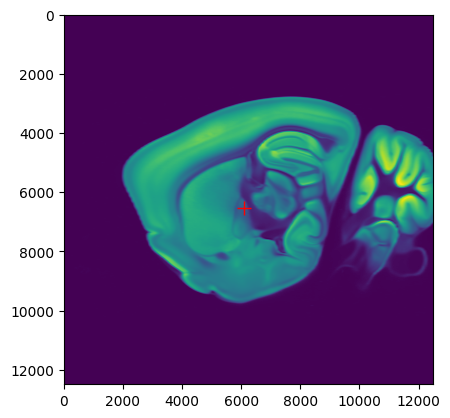

In [19]:
visualize_landmarks(virtual_slice, df['virtual_slice_coordinate'])

In [20]:
# jdict['Ctgf-T2A-dgCre;Ai14-553529.08.06b'] = jdict[' Ctgf-T2A-dgCre;Ai14-553529.08.06b']
# del jdict[' Ctgf-T2A-dgCre;Ai14-553529.08.06b']
for c in jdict.keys():
    print('|{}|'.format(c))

|Pvalb-IRES-Cre;Ai14-553660.05.06.01|
|Pvalb-IRES-Cre;Ai14-553660.05.06.02|
|Pvalb-IRES-Cre;Ai14-553660.05.06a|
|Pvalb-IRES-Cre;Ai14-553660.05.06b|
|Pvalb-IRES-Cre;Ai14-553660.05.06c|


In [21]:
df

,specimen_id,specimen_name,cell_depth,img_type,draw_type,poly_id,biospecimen_id,poly_coords,mag,dispattr,res,layer_acronym,center_pixel,center_micron,ccf_coordinate,virtual_slice_coordinate
36,1064228044,Pvalb-IRES-Cre;Ai14-553660.05.06.02,12.5,Primary,Soma,1105255986,1.064228e+09,"11578,9206,11562,9216,11549,9232,11548,9239,11...",None,--- !ruby/hash:AIBS::VectorGraphics::DisplayAt...,0.3603,None,"[11567.083333333334, 9229.166666666666]","[4167.620125, 3325.2687499999997]","[-8261.5, 6419.460536805739, -4270.5308264682435]","(6094.46053680574, 6533.030826468244)"


In [22]:
lndmrks = get_landmark_ids(specimen_id)
ldf = pd.DataFrame()
for c in lndmrks:
#     print(c)
    this_lndmrk = get_landmark_location(c[0])
    ldf = pd.concat([ldf, this_lndmrk])
    
ldf['center_pixel'] = [compute_center_from_polyline(p) for p in ldf['poly_coords']]
ldf['overview_coordinate'] = [np.multiply(p,overview_spacing) for p in ldf['center_pixel']]
# ldf['center_micron'] = [np.multiply(p,overview_spacing) for p in ldf['center_pixel']]

ldf['ccf_coordinate'] = [jdict[p] for p in ldf['specimen_name']]
ldf['virtual_slice_coordinate'] = [ ccf_to_virtual_slice_transform.TransformPoint(p)[:2] for p in ldf['ccf_coordinate'] ]

# adf['virtual_slice_coordinate'] = [virtual_slice.TransformIndexToPhysicalPoint(p) for p in adf['virtual_slice_pixel']]
# adf['overview_coordinate'] = [downsampled_overview.TransformIndexToPhysicalPoint(p) for p in adf['downsampled_overview_pixel']]
ldf                   


,specimen_id,specimen_name,cell_depth,img_type,draw_type,poly_id,biospecimen_id,poly_coords,mag,dispattr,res,layer_acronym,center_pixel,overview_coordinate,ccf_coordinate,virtual_slice_coordinate
0,1173698308,Pvalb-IRES-Cre;Ai14-553660.05.06c,None,Primary,Fiducial,1173708342,1173698308,"8877,13040,8930,12739,9138,12998,8877,13040",None,--- !ruby/hash:AIBS::VectorGraphics::DisplayAt...,0.3603,None,"[8955.5, 12954.25]","[3226.66665, 4667.4162750000005]","[-8261.5, 5733.518440148775, -5910.969078621232]","(5408.518440148776, 8173.469078621232)"
0,1173698279,Pvalb-IRES-Cre;Ai14-553660.05.06b,None,Primary,Fiducial,1173708345,1173698279,"14724,13718,14786,13503,14938,13729,14724,13718",None,--- !ruby/hash:AIBS::VectorGraphics::DisplayAt...,0.3603,None,"[14793.0, 13667.0]","[5329.9179, 4924.2201000000005]","[-8261.5, 7629.996018292391, -5531.673562992509]","(7304.996018292392, 7794.17356299251)"
0,1173697039,Pvalb-IRES-Cre;Ai14-553660.05.06a,None,Primary,Fiducial,1173708347,1173697039,"14128,7674,14335,7476,14377,7762,14128,7674",None,--- !ruby/hash:AIBS::VectorGraphics::DisplayAt...,0.3603,None,"[14242.0, 7646.5]","[5131.3926, 2755.03395]","[-8261.5, 6928.299314379254, -3274.8652450016043]","(6603.299314379255, 5537.365245001605)"


In [23]:
lndmrks

[[1173698308, 'Pvalb-IRES-Cre;Ai14-553660.05.06c'],
 [1173698279, 'Pvalb-IRES-Cre;Ai14-553660.05.06b'],
 [1173697039, 'Pvalb-IRES-Cre;Ai14-553660.05.06a']]

[3226.66665  4667.416275]
[5329.9179 4924.2201]
[5131.3926  2755.03395]


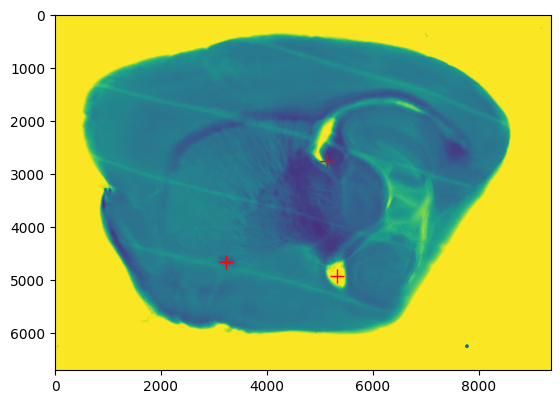

In [24]:
visualize_landmarks(downsampled_overview, ldf['overview_coordinate'])

(5408.518440148776, 8173.469078621232)
(7304.996018292392, 7794.17356299251)
(6603.299314379255, 5537.365245001605)


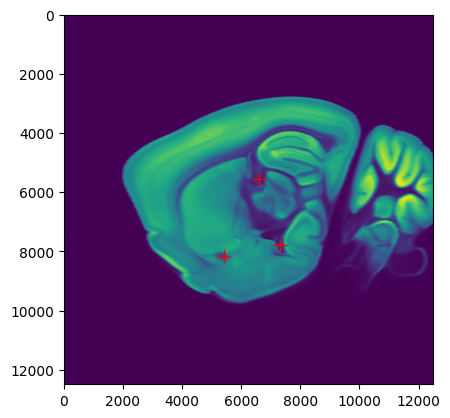

In [25]:
visualize_landmarks(virtual_slice, ldf['virtual_slice_coordinate'])

In [26]:
#
#
# == Concatentate landmarks (cell soma + additional) for registration
#

# virtual slice (fixed) landmarks
fixed_landmarks = [tuple(p) for p in df['virtual_slice_coordinate']]
fixed_landmarks.extend([tuple(p) for p in ldf['virtual_slice_coordinate']] )

# overview (moving) landmarks
moving_landmarks = [tuple(p) for p in df['center_micron']]
moving_landmarks.extend([tuple(p) for p in ldf['overview_coordinate']] )

In [29]:
moving_landmarks

[(4167.620125, 3325.2687499999997),
 (3226.66665, 4667.4162750000005),
 (5329.9179, 4924.2201000000005),
 (5131.3926, 2755.03395)]

In [30]:
## # virtual_slice_to_overview_transform :
#    - transform a 2D point (in microns) in the virtual slice to overview image (in microns)
#
# overview_to_virtual_slice_transform:
#     - transform a 3D point in overview image (in microns) to virtual slice (in microns)
#

virtual_slice_to_overview_transform = \
    sitk.LandmarkBasedTransformInitializer( sitk.AffineTransform(2), flatten(fixed_landmarks), flatten(moving_landmarks) )

overview_to_virtual_slice_transform = virtual_slice_to_overview_transform.GetInverse()

#
# == write out the overview_to_virtual_slice_transform
#
file = os.path.join(working_directory,'overview_to_virtual_slice_transform.txt')
sitk.WriteTransform( overview_to_virtual_slice_transform, file )

In [31]:
for m in pinning_info['markups']:
    print(m['name'], m['markup']['type'])

Pvalb-IRES-Cre;Ai14-553660.05.06.01 Fiducial
Pvalb-IRES-Cre;Ai14-553660.05.06.02 Fiducial
Pvalb-IRES-Cre;Ai14-553660.05.06a Fiducial
Pvalb-IRES-Cre;Ai14-553660.05.06b Fiducial
Pvalb-IRES-Cre;Ai14-553660.05.06c Fiducial


In [32]:
df

,specimen_id,specimen_name,cell_depth,img_type,draw_type,poly_id,biospecimen_id,poly_coords,mag,dispattr,res,layer_acronym,center_pixel,center_micron,ccf_coordinate,virtual_slice_coordinate
36,1064228044,Pvalb-IRES-Cre;Ai14-553660.05.06.02,12.5,Primary,Soma,1105255986,1.064228e+09,"11578,9206,11562,9216,11549,9232,11548,9239,11...",None,--- !ruby/hash:AIBS::VectorGraphics::DisplayAt...,0.3603,None,"[11567.083333333334, 9229.166666666666]","[4167.620125, 3325.2687499999997]","[-8261.5, 6419.460536805739, -4270.5308264682435]","(6094.46053680574, 6533.030826468244)"


(4167.620125, 3325.2687499999997)
(3226.66665, 4667.4162750000005)
(5329.9179, 4924.2201000000005)
(5131.3926, 2755.03395)


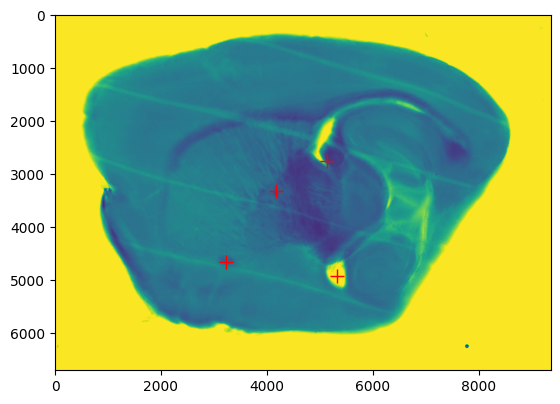

In [33]:
visualize_landmarks(downsampled_overview, moving_landmarks)

(6094.46053680574, 6533.030826468244)
(5408.518440148776, 8173.469078621232)
(7304.996018292392, 7794.17356299251)
(6603.299314379255, 5537.365245001605)


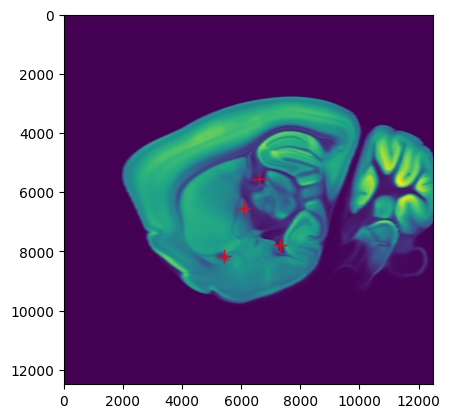

In [34]:
# view combined landmarks on CCF
visualize_landmarks( virtual_slice, fixed_landmarks)

In [35]:
# list = ['966905488',
#  '855783147',
#  '689306781',
#  '893647190',
#  '819770858',
#  '681546151',
#  '808920264',
#  '1037452707',
#  '907585117',
#  '1069256863',
#  '894610619']

# for n in list:
#     na = get_name_by_id(n)
#     print(n , na)

(6094.46053680574, 6533.030826468244)
(5408.518440148776, 8173.469078621232)
(7304.996018292392, 7794.17356299251)
(6603.299314379255, 5537.365245001605)


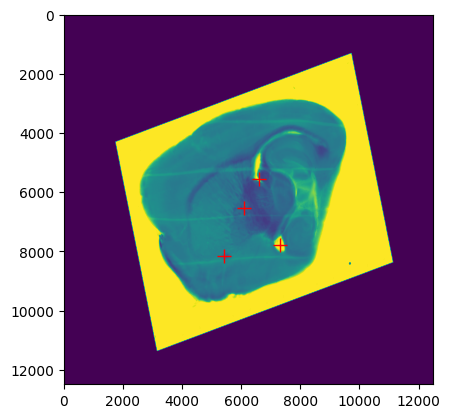

In [36]:
#
# == generate resampled overview image
#

resampled_overview = \
    sitk.Resample(downsampled_overview, virtual_slice, virtual_slice_to_overview_transform, \
                  sitk.sitkLinear, 0, downsampled_overview.GetPixelID())

visualize_landmarks( resampled_overview, fixed_landmarks )

#
# == write the downsampled overview to file
#
file = os.path.join(working_directory,'resampled_overview.nii.gz')
sitk.WriteImage( resampled_overview, file, True ) 

In [37]:
#
#
# To transform morphology file into CCF space
#
# 1) download the morphology from LIMS
# 2) if needed convert coordinates to micron - using the resolution of the 63x image
# 3) if needed correct for shrinkage - this should only affect the z coordinate!
# 4) translate the (x,y) coorinates of the morphology such that the soma node is in the corresponding position in the overview image
# 5) transform the morphology to match the virtual slice
# ---- apply "overview_to_virtual_slice_transform" to the (x,y) coordinates of the morphology
# 6) transform from virtual slice to CCF space
# ---- apply "virtual_slice_to_ccf_transform" to the (x,y,z) coordinates of the morphology
#
# **confirm back to PIR (ccf coords) since itk transforms are in LPS (-SWB)

In [38]:
# import psycopg2
# import h5py
# import numpy as np
# import logging
# import shutil
# from scipy.spatial.distance import euclidean
# from pandas import DataFrame, Series

# CONNECTION_STRING = 'host=limsdb2 dbname=lims2 user=limsreader password=limsro'
# # out= r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\human_culture\swc_files'

In [39]:
import csv

def to_dict(swc_file):
    nodes = {}
    with open(swc_file, "r") as f:
        for line in f:
            if line.lstrip().startswith('#'):
                continue
            toks = line.split()
            node_dict = {
                'id' : int(toks[0]),
                'type' : int(toks[1]),
                'x' : float(toks[2]),
                'y' : float(toks[3]),
                'z' : float(toks[4]),
                'radius' : float(toks[5]),
                'parent' : int(toks[6].rstrip())
            }
            nodes[int(toks[0])] = node_dict
    return nodes




def shift(x, y, z, morpho):
	for node in morpho.keys():
		morpho[node]['x'] += x
		morpho[node]['y'] += y
		morpho[node]['z'] += z
		
	return morpho
    

def read_marker_file(file_name):
    """ read in a marker file and return a list of dictionaries """
    markers = []
    with open(file_name, "r") as f:
        for line in f:
            if line.lstrip().startswith('#'):
                continue
            toks = line.split(',')
#             print(toks)
            marker_dict = {

                'x' : float(toks[0]),
                'y' : float(toks[1]),
                'z' : float(toks[2]),
                'name' : int(toks[5])
            }
            markers.append(marker_dict)
    return markers


In [40]:
def get_swc_from_lims(specimen_id):
    conn = psycopg2.connect(CONNECTION_STRING)
    cur = conn.cursor()

    SQL = "SELECT f.filename, f.storage_directory FROM \
     neuron_reconstructions n JOIN well_known_files f ON n.id = f.attachable_id \
     AND n.specimen_id = %s AND n.manual AND NOT n.superseded AND f.well_known_file_type_id = 303941301"
    cur.execute(SQL, (specimen_id,))
    result = cur.fetchone()

    if result is None:
        print("No SWC file found for specimen ID {}".format(specimen_id))
        return

    swc_filename = result[0]
    swc_path = result[1] + result[0]
#     print "SWC file: " + swc_path

    cur.close()
    conn.close()
    return swc_filename, swc_path

In [41]:
def query(sql, args):
    conn = psycopg2.connect(CONNECTION_STRING)
    cur = conn.cursor()

    cur.execute(sql, args)
    results = cur.fetchall()

    cur.close()
    conn.close()

    return results

def get_marker_file_from_lims(specimen_id):
    SQL = "SELECT f.filename, f.storage_directory FROM \
     neuron_reconstructions n JOIN well_known_files f ON n.id = f.attachable_id \
     AND n.specimen_id = %s AND n.manual AND NOT n.superseded AND f.well_known_file_type_id = 486753749"
    result = query(SQL, (specimen_id,))[0]
    marker_path = result[1] + result[0]
    return marker_path

def identify_soma_marker( markers):
    soma_markers = [m for m in markers if m["name"] == 30] # 30 is the code for soma marker
    soma_marker = soma_markers[0]

    return soma_marker



def scale_factor(specimen_id, morph):
    cut_thickness=350
 
    sql = f"""
    select sp.id, sp.cell_depth from specimens sp
    where sp.id = {specimen_id}
    """

    result = query(sql, specimen_id)[0]
#     print(result)
    cell_depth = list(result)[1]#['cell_depth']

    marker_path = get_marker_file_from_lims(str(specimen_id))
    marker_path = edit_path(marker_path)
    markers = read_marker_file(marker_path)
    soma = morph[1]

    soma_marker = identify_soma_marker(markers)
    if (soma_marker is not None) and (cell_depth is not None):
        z_level = soma_marker["z"]
        fixed_depth = np.abs(soma["z"] - z_level)

        if np.allclose(fixed_depth, 0):
            return np.nan

        scale = cell_depth / fixed_depth
        all_z = [c["z"] for c in morph.values()]
        max_z_extent = np.max(all_z) - np.min(all_z)
        min_slice_thickness = max_z_extent * scale

        if min_slice_thickness <= cut_thickness:
            corrected_scale = scale
        else:
            corrected_scale = cut_thickness / max_z_extent
    else:
        all_z = [c["z"] for c in morph.values()]
        max_z_extent = np.max(all_z) - np.min(all_z)
        corrected_scale = cut_thickness / max_z_extent

    return corrected_scale

def edit_path(p):
    p = p.replace('\\', '/')
    p = p.replace('/', '//', 1)
    return p

In [42]:
def convert_coords_str(coords_str):
    vals = coords_str.split(',')
    x = np.array(vals[0::2], dtype=float)
    y = np.array(vals[1::2], dtype=float)
    return x, y


In [475]:
def dict_to_swc(neuron_dict, filename):
	"""
	Takes a neuron dictionary and converts to a swc file
	"""
	f = open(filename, 'w')
	f.write("# id,type,x,y,z,r,pid\n")
	for l, vals in neuron_dict.items():
		f.write("%d %d " % (vals['id'] , vals['type']))
		f.write("%.4f " % vals['x'])
		f.write("%.4f " % vals['y'])
		f.write("%.4f " % vals['z'])
		f.write("%.4f " % vals['radius'])
		f.write("%d\n" % vals['parent'])
	f.close()

In [476]:
df.to_csv(os.path.join(working_directory, 'alignment_output.csv'), index=False)

In [477]:
cell_soma_info = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\lims_queries\cell_soma_structure_and_coords\cell_soma_information_20230621.csv')

In [480]:
#FROM LIMS
out = os.path.join(working_directory, 'swc_files')#r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\subcortical\standardization\swc_files'

if not os.path.exists(out):
    os.mkdir(out)

cells_with_issues = []
# df.reset_index(inplace=True)
for ix, this_row in df.iterrows():
    # if ix > 42:
    #     break
#     cell_id = '02'
#     this_row = df[df['specimen_name'] == '{}.{}'.format(specimen_name, cell_id)]
    # try:
    sp_name = this_row['specimen_name']#.values[0]
    sp_id = this_row['specimen_id']#.values[0]
    print("{}: {}({})".format(ix, sp_name, sp_id))
    virt_soma = list(this_row['virtual_slice_coordinate'])#.values[0])
    lims_soma = list(this_row['center_micron'])#.values[0])

    # get_swc_from_lims(1078632197)

    # 1) download the morphology from LIMS
    print('Starting step 1')
    swc_path = list(get_swc_from_lims(str(sp_id)))[1]
    print(swc_path)
    swc_path = edit_path(swc_path)
    morph = to_dict(swc_path)
    dict_to_swc(morph, os.path.join(out, '{}.swc'.format(sp_id)))
    soma = morph[1]

    # 3) if needed correct for shrinkage - this should only affect the z coordinate!
    print('Starting step 3')
    z_scale = scale_factor(sp_id, morph)
    for k,v in morph.items():
        cz = v['z']
        morph[k]['z'] = cz * z_scale

    # 4) translate the (x,y) coorinates of the morphology such that the soma node is in 
    #    the corresponding position in the overview image
    print('Starting step 4')
    x_shift = lims_soma[0] - soma['x']
    y_shift = lims_soma[1] - soma['y']
    morph = shift( x_shift, y_shift, 0, morph)
    dict_to_swc(morph, os.path.join(out, '{}_shifted_soma.swc'.format(sp_id)))

    # 5) transform the morphology to match the virtual slice
    # ---- apply "overview_to_virtual_slice_transform" to the (x,y) coordinates of the morphology
    print('Starting step 5')
    for k,v in morph.items():
        point = [v['x'], v['y']]
        tpoint = list(overview_to_virtual_slice_transform.TransformPoint(point))
        morph[k]['x'] =  tpoint[0]
        morph[k]['y'] =  tpoint[1]
    dict_to_swc(morph, os.path.join(out, '{}_to_virtual.swc'.format(sp_id)))

    # 6) transform from virtual slice to CCF space
    # ---- apply "virtual_slice_to_ccf_transform" to the (x,y,z) coordinates of the morphology
    print('Starting step 6')
    for k,v in morph.items():
        point = [v['x'], v['y'], v['z']]
        tpoint = list(virtual_slice_to_ccf_transform.TransformPoint(point))
        morph[k]['x'] =  tpoint[0]
        morph[k]['y'] =  tpoint[1]
        morph[k]['z'] =  tpoint[2]

    dict_to_swc(morph, os.path.join(out, '{}_reoriented.swc'.format(sp_id)))
    
    # 6) shift to provided ccf soma coordinate
    print('Starting step 6b')
    soma = morph[1]
    ccf_soma = list(get_ccf_coord(sp_id))
    print(ccf_soma)
    x_shift = ccf_soma[0] - soma['x']
    y_shift = ccf_soma[1] - soma['y']
    z_shift = ccf_soma[2] - soma['z']
    morph = shift( x_shift, y_shift, z_shift, morph)
    dict_to_swc(morph, os.path.join(out, '{}_reoriented+shifted.swc'.format(sp_id)))


      

    # except:
    #     print('\tIssues with this cell...')
    #     cells_with_issues.append(sp_id)

36: Pvalb-IRES-Cre;Ai14-553660.05.06.02(1064228044)
Starting step 1
/allen/programs/celltypes/production/mousecelltypes/prod3119/specimen_1064228044/Pvalb-IRES-Cre_Ai14-553660.05.06.02_1133390160_m.swc
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 6b


IndexError: list index out of range

convert to PIR at the end - swb

In [481]:
#FROM LIMS
out = os.path.join(working_directory, 'swc_files')#r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\subcortical\standardization\swc_files'

if not os.path.exists(out):
    os.mkdir(out)

cells_with_issues = []
# df.reset_index(inplace=True)
for ix, this_row in df.iterrows():
    # if ix > 42:
    #     break
#     cell_id = '02'
#     this_row = df[df['specimen_name'] == '{}.{}'.format(specimen_name, cell_id)]
    try:
        sp_name = this_row['specimen_name']#.values[0]
        sp_id = this_row['specimen_id']#.values[0]
        print("{}: {}({})".format(ix, sp_name, sp_id))
        virt_soma = list(this_row['virtual_slice_coordinate'])#.values[0])
        lims_soma = list(this_row['center_micron'])#.values[0])

        # get_swc_from_lims(1078632197)

        # 1) download the morphology from LIMS
        print('Starting step 1')
        swc_path = list(get_swc_from_lims(str(sp_id)))[1]
        print(swc_path)
        swc_path = edit_path(swc_path)
        morph = to_dict(swc_path)
        dict_to_swc(morph, os.path.join(out, '{}.swc'.format(sp_id)))
        soma = morph[1]

        # 3) if needed correct for shrinkage - this should only affect the z coordinate!
        print('Starting step 3')
        z_scale = scale_factor(sp_id, morph)
        for k,v in morph.items():
            cz = v['z']
            morph[k]['z'] = cz * z_scale

        # 4) translate the (x,y) coorinates of the morphology such that the soma node is in 
        #    the corresponding position in the overview image
        print('Starting step 4')
        x_shift = lims_soma[0] - soma['x']
        y_shift = lims_soma[1] - soma['y']
        morph = shift( x_shift, y_shift, 0, morph)
        dict_to_swc(morph, os.path.join(out, '{}_shifted_soma_pir.swc'.format(sp_id)))

        # 5) transform the morphology to match the virtual slice
        # ---- apply "overview_to_virtual_slice_transform" to the (x,y) coordinates of the morphology
        print('Starting step 5')
        for k,v in morph.items():
            point = [v['x'], v['y']]
            tpoint = list(overview_to_virtual_slice_transform.TransformPoint(point))
            morph[k]['x'] =  tpoint[0]
            morph[k]['y'] =  tpoint[1]
        dict_to_swc(morph, os.path.join(out, '{}_to_virtual_pir.swc'.format(sp_id)))

        # 6) transform from virtual slice to CCF space
        # ---- apply "virtual_slice_to_ccf_transform" to the (x,y,z) coordinates of the morphology
        print('Starting step 6')
        for k,v in morph.items():
            point = [v['x'], v['y'], v['z']]
            tpoint = list(virtual_slice_to_ccf_transform.TransformPoint(point))
            morph[k]['x'] =  tpoint[0]
            morph[k]['y'] =  tpoint[1]
            morph[k]['z'] =  tpoint[2]

        dict_to_swc(morph, os.path.join(out, '{}_reoriented.swc'.format(sp_id)))

        #SWB transform data to PIR coords (what ccf is in) from LPS (if that's what this is)
        x = [0,1,0,
             0,0,-1,
             -1,0,0]
        x = np.reshape(x,(3,3))
        for k,v in morph.items():
            point = [v['x'], v['y'], v['z']]
            point = np.reshape(point, (3,1))
            pir_point = np.matmul(x,point)
            morph[k]['x'] =  pir_point[0]
            morph[k]['y'] =  pir_point[1]
            morph[k]['z'] =  pir_point[2]
        dict_to_swc(morph, os.path.join(out, '{}_reoriented_pir.swc'.format(sp_id)))
        
        # 6) shift to provided ccf soma coordinate
        print('Starting step 6b')
        soma = morph[1]
        ccf_soma = list(get_ccf_coord(sp_id))
        x_shift = ccf_soma[0] - soma['x']
        y_shift = ccf_soma[1] - soma['y']
        z_shift = ccf_soma[2] - soma['z']
        morph = shift( x_shift, y_shift, z_shift, morph)
        dict_to_swc(morph, os.path.join(out, '{}_reoriented+shifted_pir.swc'.format(sp_id)))

    except:
        print('\tIssues with this cell...')
        cells_with_issues.append(sp_id)

36: Pvalb-IRES-Cre;Ai14-553660.05.06.02(1064228044)
Starting step 1
/allen/programs/celltypes/production/mousecelltypes/prod3119/specimen_1064228044/Pvalb-IRES-Cre_Ai14-553660.05.06.02_1133390160_m.swc
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 6b
	Issues with this cell...


In [482]:
#get soma loc in ccf from json, not from lims. 
#This should work for cells pinned with new pinning tool.

def get_ccf_coord_jblob(name, cell_soma_info):
    row = cell_soma_info[cell_soma_info.specimen_name == name].iloc[0]
    return row.x, row.y, row.z

In [483]:
#FROM JBLOB
out = os.path.join(working_directory, 'swc_files')#r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\subcortical\standardization\swc_files'

if not os.path.exists(out):
    os.mkdir(out)

cells_with_issues = []
# df.reset_index(inplace=True)
for ix, this_row in df.iterrows():
    # if ix > 42:
    #     break
#     cell_id = '02'
#     this_row = df[df['specimen_name'] == '{}.{}'.format(specimen_name, cell_id)]
    # try:
    sp_name = this_row['specimen_name']#.values[0]
    sp_id = this_row['specimen_id']#.values[0]
    print("{}: {}({})".format(ix, sp_name, sp_id))
    virt_soma = list(this_row['virtual_slice_coordinate'])#.values[0])
    lims_soma = list(this_row['center_micron'])#.values[0])

    # get_swc_from_lims(1078632197)

    # 1) download the morphology from LIMS
    print('Starting step 1')
    swc_path = list(get_swc_from_lims(str(sp_id)))[1]
    print(swc_path)
    swc_path = edit_path(swc_path)
    morph = to_dict(swc_path)
    dict_to_swc(morph, os.path.join(out, '{}.swc'.format(sp_id)))
    soma = morph[1]

    # 3) if needed correct for shrinkage - this should only affect the z coordinate!
    print('Starting step 3')
    z_scale = scale_factor(sp_id, morph)
    for k,v in morph.items():
        cz = v['z']
        morph[k]['z'] = cz * z_scale

    # 4) translate the (x,y) coorinates of the morphology such that the soma node is in 
    #    the corresponding position in the overview image
    print('Starting step 4')
    x_shift = lims_soma[0] - soma['x']
    y_shift = lims_soma[1] - soma['y']
    morph = shift( x_shift, y_shift, 0, morph)
    dict_to_swc(morph, os.path.join(out, '{}_shifted_soma_jblob.swc'.format(sp_id)))

    # 5) transform the morphology to match the virtual slice
    # ---- apply "overview_to_virtual_slice_transform" to the (x,y) coordinates of the morphology
    print('Starting step 5')
    for k,v in morph.items():
        point = [v['x'], v['y']]
        tpoint = list(overview_to_virtual_slice_transform.TransformPoint(point))
        morph[k]['x'] =  tpoint[0]
        morph[k]['y'] =  tpoint[1]
    dict_to_swc(morph, os.path.join(out, '{}_to_virtual_jblob.swc'.format(sp_id)))

    # 6) transform from virtual slice to CCF space
    # ---- apply "virtual_slice_to_ccf_transform" to the (x,y,z) coordinates of the morphology
    print('Starting step 6')
    for k,v in morph.items():
        point = [v['x'], v['y'], v['z']]
        tpoint = list(virtual_slice_to_ccf_transform.TransformPoint(point))
        morph[k]['x'] =  tpoint[0]
        morph[k]['y'] =  tpoint[1]
        morph[k]['z'] =  tpoint[2]

    dict_to_swc(morph, os.path.join(out, '{}_reoriented_jblob.swc'.format(sp_id)))
    
    # 6) shift to provided ccf soma coordinate
    print('Starting step 6b')
    soma = morph[1]
    ccf_soma = list(get_ccf_coord_jblob(sp_name, cell_soma_info))
    print(ccf_soma)
    x_shift = ccf_soma[0] - soma['x']
    y_shift = ccf_soma[1] - soma['y']
    z_shift = ccf_soma[2] - soma['z']
    morph = shift( x_shift, y_shift, z_shift, morph)
    dict_to_swc(morph, os.path.join(out, '{}_reoriented+shifted_jblob.swc'.format(sp_id)))


      

    # except:
    #     print('\tIssues with this cell...')
    #     cells_with_issues.append(sp_id)

36: Pvalb-IRES-Cre;Ai14-553660.05.06.02(1064228044)
Starting step 1
/allen/programs/celltypes/production/mousecelltypes/prod3119/specimen_1064228044/Pvalb-IRES-Cre_Ai14-553660.05.06.02_1133390160_m.swc
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 6b
[6419.460536805739, 4270.530826468244, 8261.5]


In [484]:
#FROM JBLOB - to PIR
out = os.path.join(working_directory, 'swc_files')#r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\subcortical\standardization\swc_files'

if not os.path.exists(out):
    os.mkdir(out)

cells_with_issues = []
# df.reset_index(inplace=True)
for ix, this_row in df.iterrows():
    # if ix > 42:
    #     break
#     cell_id = '02'
#     this_row = df[df['specimen_name'] == '{}.{}'.format(specimen_name, cell_id)]
    # try:
    sp_name = this_row['specimen_name']#.values[0]
    sp_id = this_row['specimen_id']#.values[0]
    print("{}: {}({})".format(ix, sp_name, sp_id))
    virt_soma = list(this_row['virtual_slice_coordinate'])#.values[0])
    lims_soma = list(this_row['center_micron'])#.values[0])

    # get_swc_from_lims(1078632197)

    # 1) download the morphology from LIMS
    print('Starting step 1')
    swc_path = list(get_swc_from_lims(str(sp_id)))[1]
    print(swc_path)
    swc_path = edit_path(swc_path)
    morph = to_dict(swc_path)
    dict_to_swc(morph, os.path.join(out, '{}.swc'.format(sp_id)))
    soma = morph[1]

    # 3) if needed correct for shrinkage - this should only affect the z coordinate!
    print('Starting step 3')
    z_scale = scale_factor(sp_id, morph)
    for k,v in morph.items():
        cz = v['z']
        morph[k]['z'] = cz * z_scale

    # 4) translate the (x,y) coorinates of the morphology such that the soma node is in 
    #    the corresponding position in the overview image
    print('Starting step 4')
    x_shift = lims_soma[0] - soma['x']
    y_shift = lims_soma[1] - soma['y']
    morph = shift( x_shift, y_shift, 0, morph)
    dict_to_swc(morph, os.path.join(out, '{}_shifted_soma_jblob.swc'.format(sp_id)))

    # 5) transform the morphology to match the virtual slice
    # ---- apply "overview_to_virtual_slice_transform" to the (x,y) coordinates of the morphology
    print('Starting step 5')
    for k,v in morph.items():
        point = [v['x'], v['y']]
        tpoint = list(overview_to_virtual_slice_transform.TransformPoint(point))
        morph[k]['x'] =  tpoint[0]
        morph[k]['y'] =  tpoint[1]
    dict_to_swc(morph, os.path.join(out, '{}_to_virtual_jblob.swc'.format(sp_id)))

    # 6) transform from virtual slice to CCF space
    # ---- apply "virtual_slice_to_ccf_transform" to the (x,y,z) coordinates of the morphology
    print('Starting step 6')
    for k,v in morph.items():
        point = [v['x'], v['y'], v['z']]
        tpoint = list(virtual_slice_to_ccf_transform.TransformPoint(point))
        morph[k]['x'] =  tpoint[0]
        morph[k]['y'] =  tpoint[1]
        morph[k]['z'] =  tpoint[2]

    dict_to_swc(morph, os.path.join(out, '{}_reoriented_jblob.swc'.format(sp_id)))

    #SWB transform data to PIR coords (what ccf is in) from LPS (if that's what this is)
    x = [0,1,0,
         0,0,-1,
        -1,0,0]
    x = np.reshape(x,(3,3))
    for k,v in morph.items():
        point = [v['x'], v['y'], v['z']]
        point = np.reshape(point, (3,1))
        pir_point = np.matmul(x,point)
        morph[k]['x'] =  pir_point[0]
        morph[k]['y'] =  pir_point[1]
        morph[k]['z'] =  pir_point[2]
    dict_to_swc(morph, os.path.join(out, '{}_reoriented_jblob_pir.swc'.format(sp_id)))
        
    
    # 6) shift to provided ccf soma coordinate
    print('Starting step 6b')
    soma = morph[1]
    ccf_soma = list(get_ccf_coord_jblob(sp_name, cell_soma_info))
    print(ccf_soma)
    x_shift = ccf_soma[0] - soma['x']
    y_shift = ccf_soma[1] - soma['y']
    z_shift = ccf_soma[2] - soma['z']
    morph = shift( x_shift, y_shift, z_shift, morph)
    dict_to_swc(morph, os.path.join(out, '{}_reoriented+shifted_jblob_pir.swc'.format(sp_id)))


      

    # except:
    #     print('\tIssues with this cell...')
    #     cells_with_issues.append(sp_id)

36: Pvalb-IRES-Cre;Ai14-553660.05.06.02(1064228044)
Starting step 1
/allen/programs/celltypes/production/mousecelltypes/prod3119/specimen_1064228044/Pvalb-IRES-Cre_Ai14-553660.05.06.02_1133390160_m.swc
Starting step 3
Starting step 4
Starting step 5
Starting step 6
Starting step 6b
[6419.460536805739, 4270.530826468244, 8261.5]


In [ ]:
get_id_by_name('C57BL6J-581850.06.03.05')

1110141970

In [ ]:
# for sp_id in cells_with_issues:
    
#     this_row = df[df.specimen_id == sp_id]
#     sp_name = this_row['specimen_name'].values[0]
# #     sp_id = this_row['specimen_id'].values[0]
#     print("{}({})".format(sp_name, sp_id))
#     virt_soma = list(this_row['virtual_slice_coordinate'])#.values[0]
#     lims_soma = list(this_row['center_micron'].values[0])

#     print('virt_soma: {}'.format(virt_soma))
#     print('lims_soma: {}'.format(lims_soma))

#     # 1) download the morphology from LIMS
#     swc_path = list(get_swc_from_lims(str(sp_id)))[1]
#     print(swc_path)
#     swc_path = edit_path(swc_path)
#     morph = to_dict(swc_path)
#     dict_to_swc(morph, os.path.join(out, '{}.swc'.format(sp_id)))
#     soma = morph[1]

#     # 3) if needed correct for shrinkage - this should only affect the z coordinate!
#     z_scale = scale_factor(sp_id, morph)
#     for k,v in morph.items():
#         cz = v['z']
#         morph[k]['z'] = cz * z_scale

#     # 4) translate the (x,y) coorinates of the morphology such that the soma node is in the corresponding position in the overview image
#     x_shift = lims_soma[0] - soma['x']
#     y_shift = lims_soma[1] - soma['y']
#     morph = shift( x_shift, y_shift, 0, morph)
#     # dict_to_swc(morph, os.path.join(out, '{}_shifted_soma.swc'.format(sp_id)))

#     # 5) transform the morphology to match the virtual slice
#     # ---- apply "overview_to_virtual_slice_transform" to the (x,y) coordinates of the morphology

#     for k,v in morph.items():
#         point = [v['x'], v['y']]
#         tpoint = list(overview_to_virtual_slice_transform.TransformPoint(point))
#         morph[k]['x'] =  tpoint[0]
#         morph[k]['y'] =  tpoint[1]
#     dict_to_swc(morph, os.path.join(out, '{}_to_virtual.swc'.format(sp_id)))

#     # 6) transform from virtual slice to CCF space
#     # ---- apply "virtual_slice_to_ccf_transform" to the (x,y,z) coordinates of the morphology

#     for k,v in morph.items():
#         point = [v['x'], v['y'], v['z']]
#         tpoint = list(virtual_slice_to_ccf_transform.TransformPoint(point))
#         morph[k]['x'] =  tpoint[0]
#         morph[k]['y'] =  tpoint[1]
#         morph[k]['z'] =  tpoint[2]

#     dict_to_swc(morph, os.path.join(out, '{}_reoriented.swc'.format(sp_id)))

#     # 6) shift to provided ccf soma coordinate
#     soma = morph[1]
#     ccf_soma = list(virt_soma[0])#list(get_ccf_coord(sp_id))
#     x_shift = ccf_soma[0] - soma['x']
#     y_shift = ccf_soma[1] - soma['y']
#     z_shift = ccf_soma[2] - soma['z']
#     morph = shift( x_shift, y_shift, z_shift, morph)
#     dict_to_swc(morph, os.path.join(out, '{}_reoriented+shifted.swc'.format(sp_id)))


In [ ]:
get_name_by_id(1063002851)

'Ctgf-T2A-dgCre;Ai14-553529.08.06.02'

In [ ]:
autotrace_folder = r'\\allen\programs\celltypes\workgroups\mousecelltypes\Matt_Mallory\AutoSegmentation\Subcortical\SWC_Files_For_Analysis\2_2_22_Analysis_FixedManualEdits\Final_Cells_2_2_22_And_LA_Soma_Fixs'
def get_autotrace_path(spec):
    swc_path = os.path.join(autotrace_folder, spec + '.swc')
    return swc_path

In [ ]:
out = os.path.join(working_directory, 'swc_files')#r'\\allen\programs\celltypes\workgroups\mousecelltypes\Alice\subcortical\standardization\swc_files'
if not os.path.exists(out):
    os.mkdir(out)

cells_with_issues = []
# df.reset_index(inplace=True)
for ix, this_row in df.iterrows():
#     cell_id = '02'
#     this_row = df[df['specimen_name'] == '{}.{}'.format(specimen_name, cell_id)]
    try:
        sp_name = this_row['specimen_name']#.values[0]
        sp_id = this_row['specimen_id']#.values[0]
        print("{}: {}({})".format(ix, sp_name, sp_id))
        virt_soma = list(this_row['virtual_slice_coordinate'])#.values[0])
        lims_soma = list(this_row['center_micron'])#.values[0])

        # get_swc_from_lims(1078632197)

        # 1) download the autotrace
        swc_path = get_autotrace_path(str(sp_id))
#         print(swc_path)
    #         swc_path = edit_path(swc_path)
        morph = to_dict(swc_path)
        dict_to_swc(morph, os.path.join(out, '{}_autotrace.swc'.format(sp_id)))
        soma = morph[1]

        # 3) if needed correct for shrinkage - this should only affect the z coordinate!
        z_scale = scale_factor(sp_id, morph)
        for k,v in morph.items():
            cz = v['z']
            morph[k]['z'] = cz * z_scale

        # 4) translate the (x,y) coorinates of the morphology such that the soma node is in the corresponding position in the overview image
        x_shift = lims_soma[0] - soma['x']
        y_shift = lims_soma[1] - soma['y']
        morph = shift( x_shift, y_shift, 0, morph)
        # dict_to_swc(morph, os.path.join(out, '{}_shifted_soma.swc'.format(sp_id)))

        # 5) transform the morphology to match the virtual slice
        # ---- apply "overview_to_virtual_slice_transform" to the (x,y) coordinates of the morphology

        for k,v in morph.items():
            point = [v['x'], v['y']]
            tpoint = list(overview_to_virtual_slice_transform.TransformPoint(point))
            morph[k]['x'] =  tpoint[0]
            morph[k]['y'] =  tpoint[1]
        dict_to_swc(morph, os.path.join(out, '{}_autotrace_to_virtual.swc'.format(sp_id)))

        # 6) transform from virtual slice to CCF space
        # ---- apply "virtual_slice_to_ccf_transform" to the (x,y,z) coordinates of the morphology

        for k,v in morph.items():
            point = [v['x'], v['y'], v['z']]
            tpoint = list(virtual_slice_to_ccf_transform.TransformPoint(point))
            morph[k]['x'] =  tpoint[0]
            morph[k]['y'] =  tpoint[1]
            morph[k]['z'] =  tpoint[2]

        dict_to_swc(morph, os.path.join(out, '{}_autotrace_reoriented.swc'.format(sp_id)))

        #SWB transform data to PIR coords (what ccf is in) from LPS (if that's what this is)
        x = [0,1,0,
             0,0,-1,
             -1,0,0]
        x = np.reshape(x,(3,3))
        for k,v in morph.items():
            point = [v['x'], v['y'], v['z']]
            point = np.reshape(point, (3,1))
            pir_point = np.matmul(x,point)
            morph[k]['x'] =  pir_point[0]
            morph[k]['y'] =  pir_point[1]
            morph[k]['z'] =  pir_point[2]
        dict_to_swc(morph, os.path.join(out, '{}_reoriented_pir.swc'.format(sp_id)))
        

    
        # 6) shift to provided ccf soma coordinate
        soma = morph[1]
        ccf_soma = list(get_ccf_coord(sp_id))
        x_shift = ccf_soma[0] - soma['x']
        y_shift = ccf_soma[1] - soma['y']
        z_shift = ccf_soma[2] - soma['z']
        morph = shift( x_shift, y_shift, z_shift, morph)
        dict_to_swc(morph, os.path.join(out, '{}_autotrace_reoriented+shifted.swc'.format(sp_id)))


    except:
        print('\tIssues with this cell...')
        cells_with_issues.append(sp_id)

48: C57BL6J-581850.06.03.05(1110141970)
	Issues with this cell...


Debugging

In [ ]:
from neuron_morphology.swc_io import *


In [ ]:
#basic cell plot
def basic_morph_plot_new(morph, 
                         ax,
                         title="",
                         morph_colors={2: "firebrick", 4: "orange", 3: "steelblue"}, 
                         side=False, 
                         xoffset=0,
                         line_w=0.35,
                         scatter=False
                        ):
    
    ax.set_title(title)
    dotsize=line_w*10
    if scatter:
        dotsize=line_w*10
        for ntype, color in morph_colors.items():
            if not side:
                nodes = np.array([ [n['x'],n['y']] for n in morph.nodes() if n['type']==ntype])
            else:
                nodes = np.array([ [n['z'],n['y']] for n in morph.nodes() if n['type']==ntype])

            try:
                ax.scatter(nodes[:,0],nodes[:,1],c=color,s=dotsize)
            except:
                its = "missing a compartment"
                
    for compartment, color in morph_colors.items():
        lines_x = []
        lines_y = []
        for c in [n for n in morph.nodes() if n['type'] == compartment]:
            if c["parent"] == -1:
                continue
            try:
                p = morph.node_by_id(c["parent"])
            except:
                p = c
                
            if side:
                lines_x += [p["z"] + xoffset, c["z"] + xoffset, None]
            else:
                lines_x += [p["x"] + xoffset, c["x"] + xoffset, None]
            lines_y += [p["y"], c["y"], None]
        lines_y = [None if v is None else 1*v for v in lines_y]
        ax.plot(lines_x, lines_y, c=color, linewidth=line_w, zorder=compartment)


#saggital view in ccf space is y(anterior-posterior) z(superior-inferior)
def basic_morph_plot_ccf(morph, 
                         ax,
                         title="",
                         morph_colors={2: "firebrick", 4: "orange", 3: "steelblue"}, 
                         xoffset=0,
                         line_w=0.35,
                         scatter=False,
                         x = 'x',
                         y = 'y'):
    
    ax.set_title(title)
    dotsize=line_w*10
    if scatter:
        dotsize=line_w*10
        for ntype, color in morph_colors.items():
            nodes = np.array([ [n[x],n[y]] for n in morph.nodes() if n['type']==ntype])
            try:
                ax.scatter(nodes[:,0],nodes[:,1],c=color,s=dotsize)
            except:
                its = "missing a compartment"
                
    for compartment, color in morph_colors.items():
        lines_x = []
        lines_y = []
        for c in [n for n in morph.nodes() if n['type'] == compartment]:
            if c["parent"] == -1:
                continue
            try:
                p = morph.node_by_id(c["parent"])
            except:
                p = c
                
            lines_x += [p[x] + xoffset, c[x] + xoffset, None]
            lines_y += [p[y], c[y], None]
        lines_y = [None if v is None else 1*v for v in lines_y]
        ax.plot(lines_x, lines_y, c=color, linewidth=line_w, zorder=compartment)

In [ ]:
# swc_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\ccf_slice_registration\standardization\Nos1-CreERT2;Sst-IRES-FlpO;Ai65-553472.08.06\swc_files'
# specimen_id = 1063317435 #no

# swc_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\ccf_slice_registration\standardization\C57BL6J-588656.06.04\swc_files'
# specimen_id = get_id_by_name('C57BL6J-588656.06.04.01') #yes

# swc_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\ccf_slice_registration\standardization\Sst-IRES-Cre;Ai14-554002.07.06\swc_files'
# specimen_id = get_id_by_name('Sst-IRES-Cre;Ai14-554002.07.06.01') #no

# swc_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\ccf_slice_registration\standardization\Slc32a1-IRES-Cre;Ai14-562359.09.09\swc_files'
# specimen_id = get_id_by_name('Slc32a1-IRES-Cre;Ai14-562359.09.09.01') #yes

# swc_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\ccf_slice_registration\standardization\Ctgf-T2A-dgCre;Ai14-553529.08.06\swc_files'
# specimen_id = 1063002851

swc_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\ccf_slice_registration\standardization\Ctgf-T2A-dgCre;Ai14-553529.08.06\swc_files'
specimen_id = 1063002851

raw_swc = os.path.join(swc_dir, '{}.swc'.format(specimen_id))
raw_shifted_swc = os.path.join(swc_dir, '{}_shifted_soma.swc'.format(specimen_id))
to_virtual_swc = os.path.join(swc_dir, '{}_to_virtual.swc'.format(specimen_id))
reoriented_swc = os.path.join(swc_dir, '{}_reoriented.swc'.format(specimen_id))
reoriented_pir_swc = os.path.join(swc_dir, '{}_reoriented_pir.swc'.format(specimen_id))
reoriented_shifted_swc = os.path.join(swc_dir, '{}_reoriented+shifted.swc'.format(specimen_id))
reoriented_shifted_pir_swc = os.path.join(swc_dir, '{}_reoriented+shifted_pir.swc'.format(specimen_id))

reoriented_shifted_jblob_swc = os.path.join(swc_dir, '{}_reoriented+shifted_jblob.swc'.format(specimen_id))



raw_nrn = morphology_from_swc(raw_swc)
raw_shifted_nrn = morphology_from_swc(raw_shifted_swc)
to_virtual_nrn = morphology_from_swc(to_virtual_swc)
reoriented_nrn = morphology_from_swc(reoriented_swc)
reoriented_pir_nrn = morphology_from_swc(reoriented_pir_swc)
reoriented_shifted_nrn = morphology_from_swc(reoriented_shifted_swc)
reoriented_shifted_pir_nrn = morphology_from_swc(reoriented_shifted_pir_swc)

reoriented_shifted_jblob_nrn = morphology_from_swc(reoriented_shifted_jblob_swc)



In [479]:
get_id_by_name('Pvalb-IRES-Cre;Ai14-553660.05.06.02')

1064228044

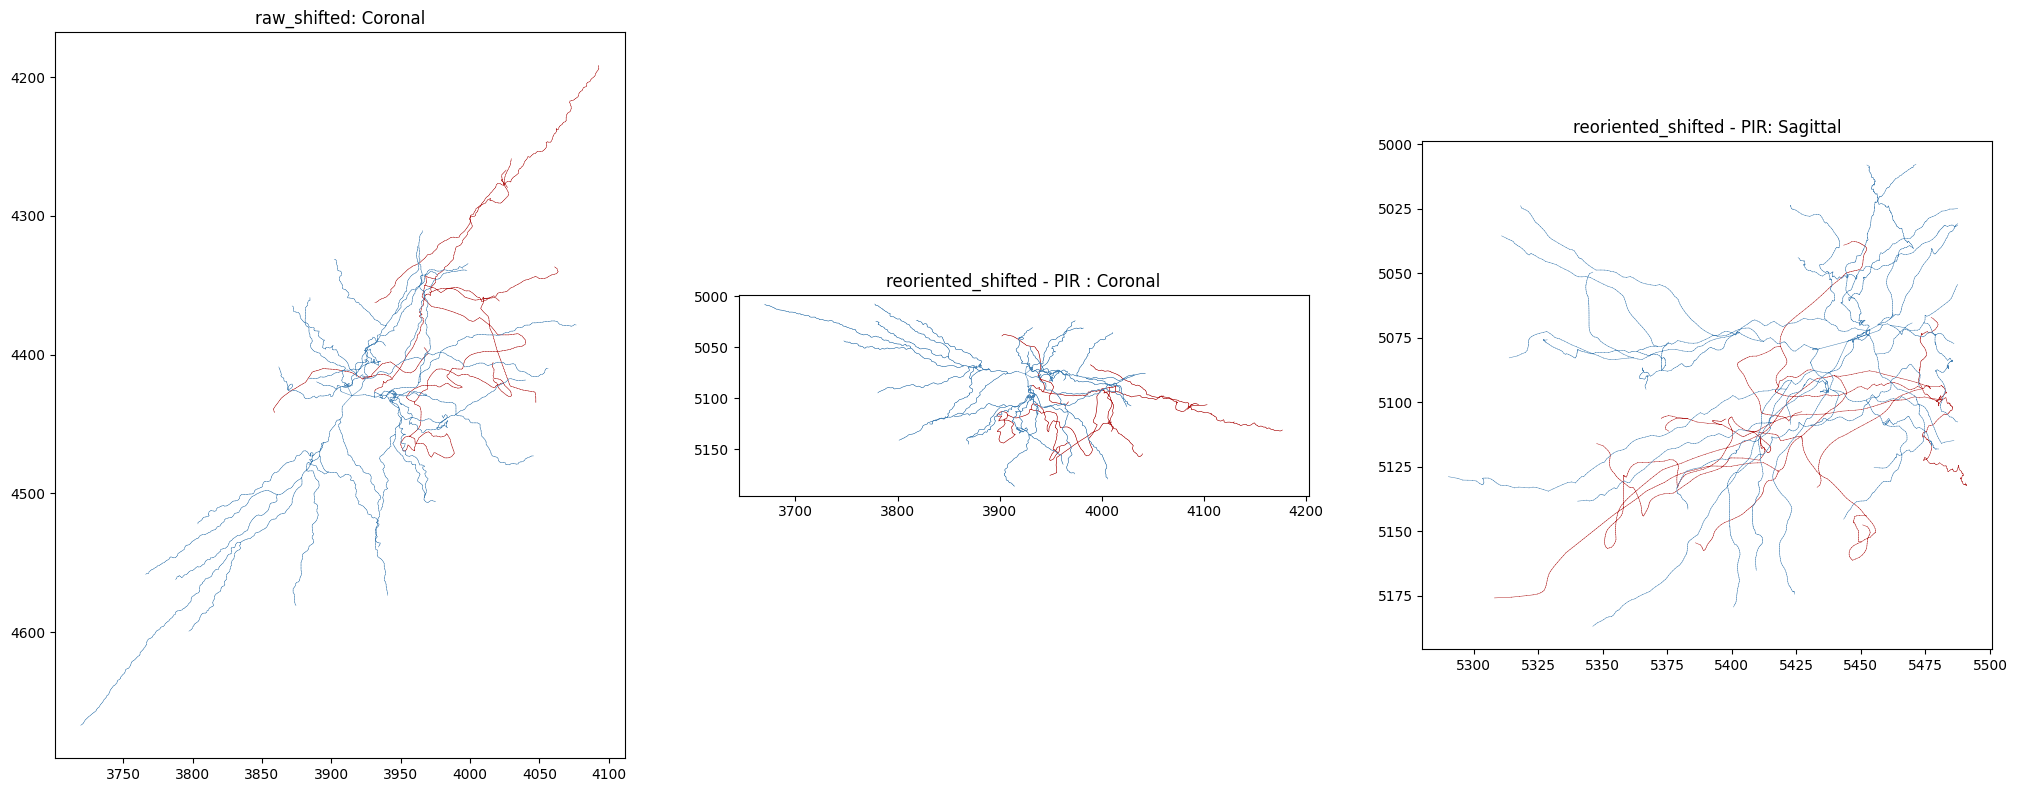

In [ ]:
#Plot final ccf registration cells 

fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(25,10)) #gridspec_kw = {'wspace':0, 'hspace':0},

nrns = {0: ['raw_shifted: ' + pinning_info['referenceView'], raw_shifted_nrn, False, '', False, True], 
        # 1 : ['reoriented_shifted - RAS : Coronal', reoriented_shifted_nrn, 'x', 'z', False, False], 
        # 2 : ['reoriented_shifted - RAS: Sagittal', reoriented_shifted_nrn, 'y', 'z', True, False], 
        # 3 : ['reoriented_shifted - LPS : Coronal', reoriented_shifted_nrn, 'x', 'z', True, False], 
        # 4 : ['reoriented_shifted - LPS: Sagittal', reoriented_shifted_nrn, 'y', 'z', False, False],
        # 5 : ['reoriented_shifted - LAS : Coronal', reoriented_shifted_nrn, 'x', 'z', True, False], 
        # 6 : ['reoriented_shifted - LAS: Sagittal', reoriented_shifted_nrn, 'y', 'z', True, False],
        1 : ['reoriented_shifted - PIR : Coronal', reoriented_shifted_nrn, 'z', 'y', False, True], 
        2 : ['reoriented_shifted - PIR: Sagittal', reoriented_shifted_nrn, 'x', 'y', False, True], 
        }
for i, ax in enumerate(axes.reshape(-1)):

    if i < 9:

        nrn = nrns[i][1]
        nrn_type = nrns[i][0]
        x = nrns[i][2]
        y = nrns[i][3]
        invert_x =  nrns[i][4]
        invert_y =  nrns[i][5]
        if i == 0:
            basic_morph_plot_new(nrn, ax, title=nrn_type, side=x )
        else: 
            basic_morph_plot_ccf(nrn, ax, title=nrn_type, x=x, y=y)

        if invert_x: ax.invert_xaxis()
        if invert_y: ax.invert_yaxis()

        ax.set_aspect('equal')

    
plt.show()

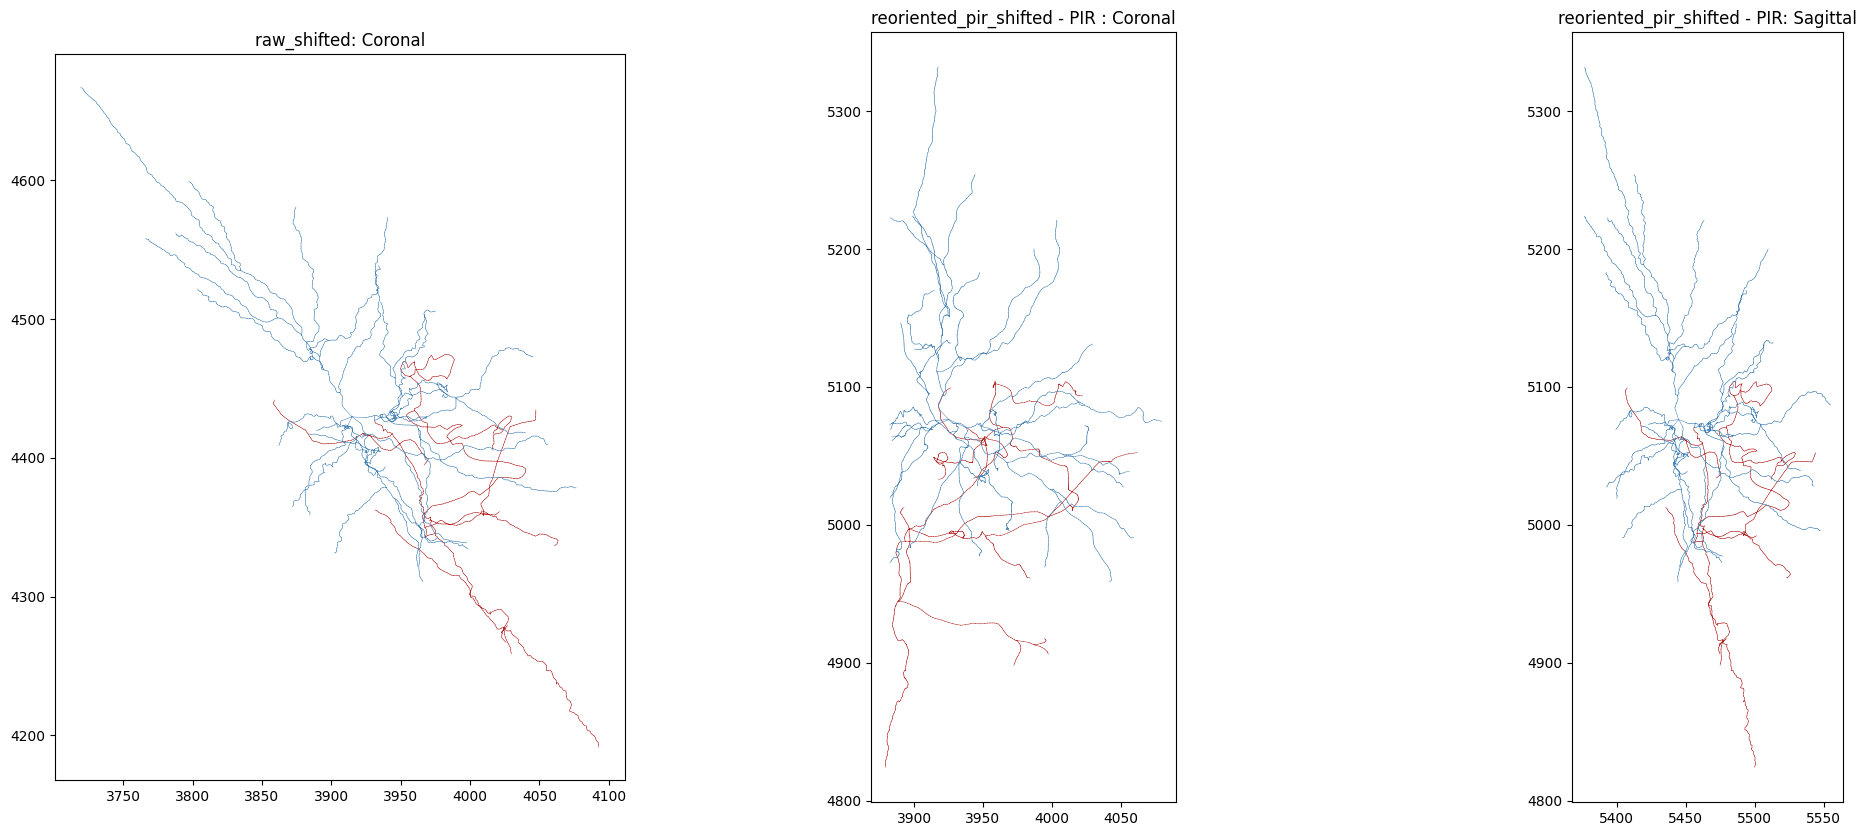

In [ ]:
#Plot final ccf registration transformed from LPS to PIR coords
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(25,10)) #gridspec_kw = {'wspace':0, 'hspace':0},

nrns = {0: ['raw_shifted: ' + pinning_info['referenceView'], raw_shifted_nrn, False, '', False, False], 
        1 : ['reoriented_pir_shifted - PIR : Coronal', reoriented_shifted_pir_nrn, 'z', 'y', False, False], 
        2 : ['reoriented_pir_shifted - PIR: Sagittal', reoriented_shifted_pir_nrn, 'x', 'y', False, False], 
        }
for i, ax in enumerate(axes.reshape(-1)):

    if i < 9:

        nrn = nrns[i][1]
        nrn_type = nrns[i][0]
        x = nrns[i][2]
        y = nrns[i][3]
        invert_x =  nrns[i][4]
        invert_y =  nrns[i][5]
        if i == 0:
            basic_morph_plot_new(nrn, ax, title=nrn_type, side=x )
        else: 
            basic_morph_plot_ccf(nrn, ax, title=nrn_type, x=x, y=y)

        if invert_x: ax.invert_xaxis()
        if invert_y: ax.invert_yaxis()

        ax.set_aspect('equal')

    
plt.show()

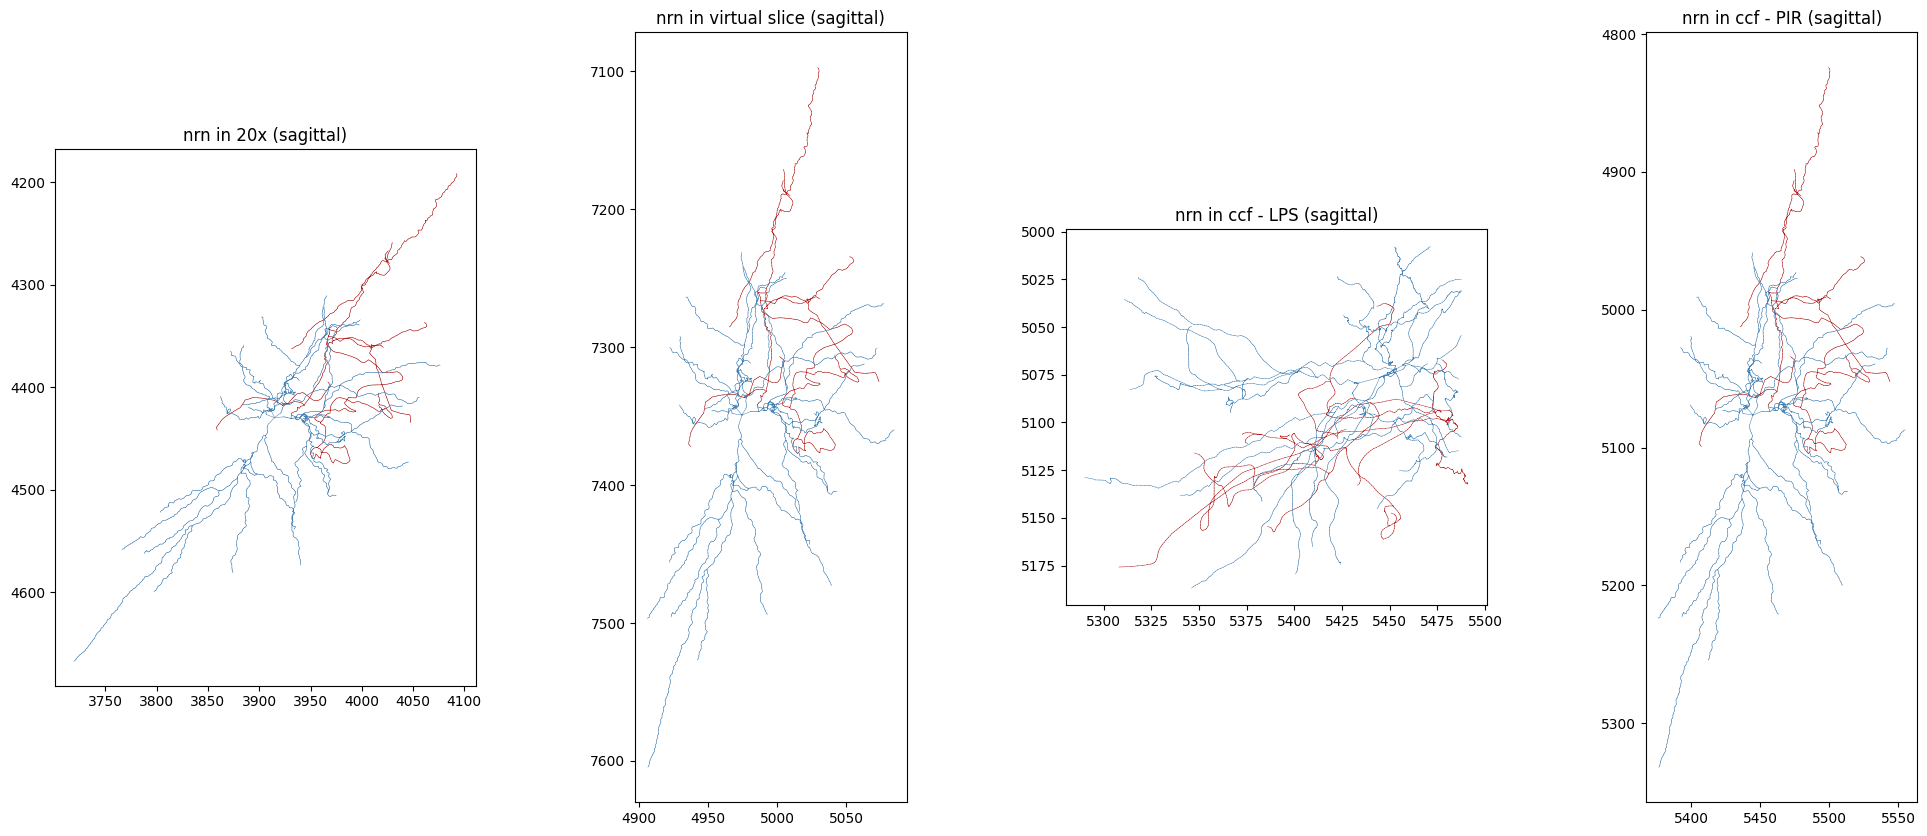

In [ ]:
#Plot final ccf registration transformed from LPS to PIR coords
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(25,10)) #gridspec_kw = {'wspace':0, 'hspace':0},

nrns = {0 : ['nrn in 20x (sagittal)', raw_shifted_nrn, False, '', False, True], 
        1 : ['nrn in virtual slice (sagittal)', to_virtual_nrn, 'x', 'y', False, True],
        2 : ['nrn in ccf - LPS (sagittal)', reoriented_shifted_nrn, 'x', 'y', False, True], 
        3 : ['nrn in ccf - PIR (sagittal)', reoriented_shifted_pir_nrn, 'x', 'y', False, True], 
        }
for i, ax in enumerate(axes.reshape(-1)):

    if i < 9:
        nrn = nrns[i][1]
        nrn_type = nrns[i][0]
        x = nrns[i][2]
        y = nrns[i][3]
        invert_x =  nrns[i][4]
        invert_y =  nrns[i][5]
        if i == 0:
            basic_morph_plot_new(nrn, ax, title=nrn_type, side=x )
        else: 
            basic_morph_plot_ccf(nrn, ax, title=nrn_type, x=x, y=y)

        if invert_x: ax.invert_xaxis()
        if invert_y: ax.invert_yaxis()

        ax.set_aspect('equal')

    
plt.show()

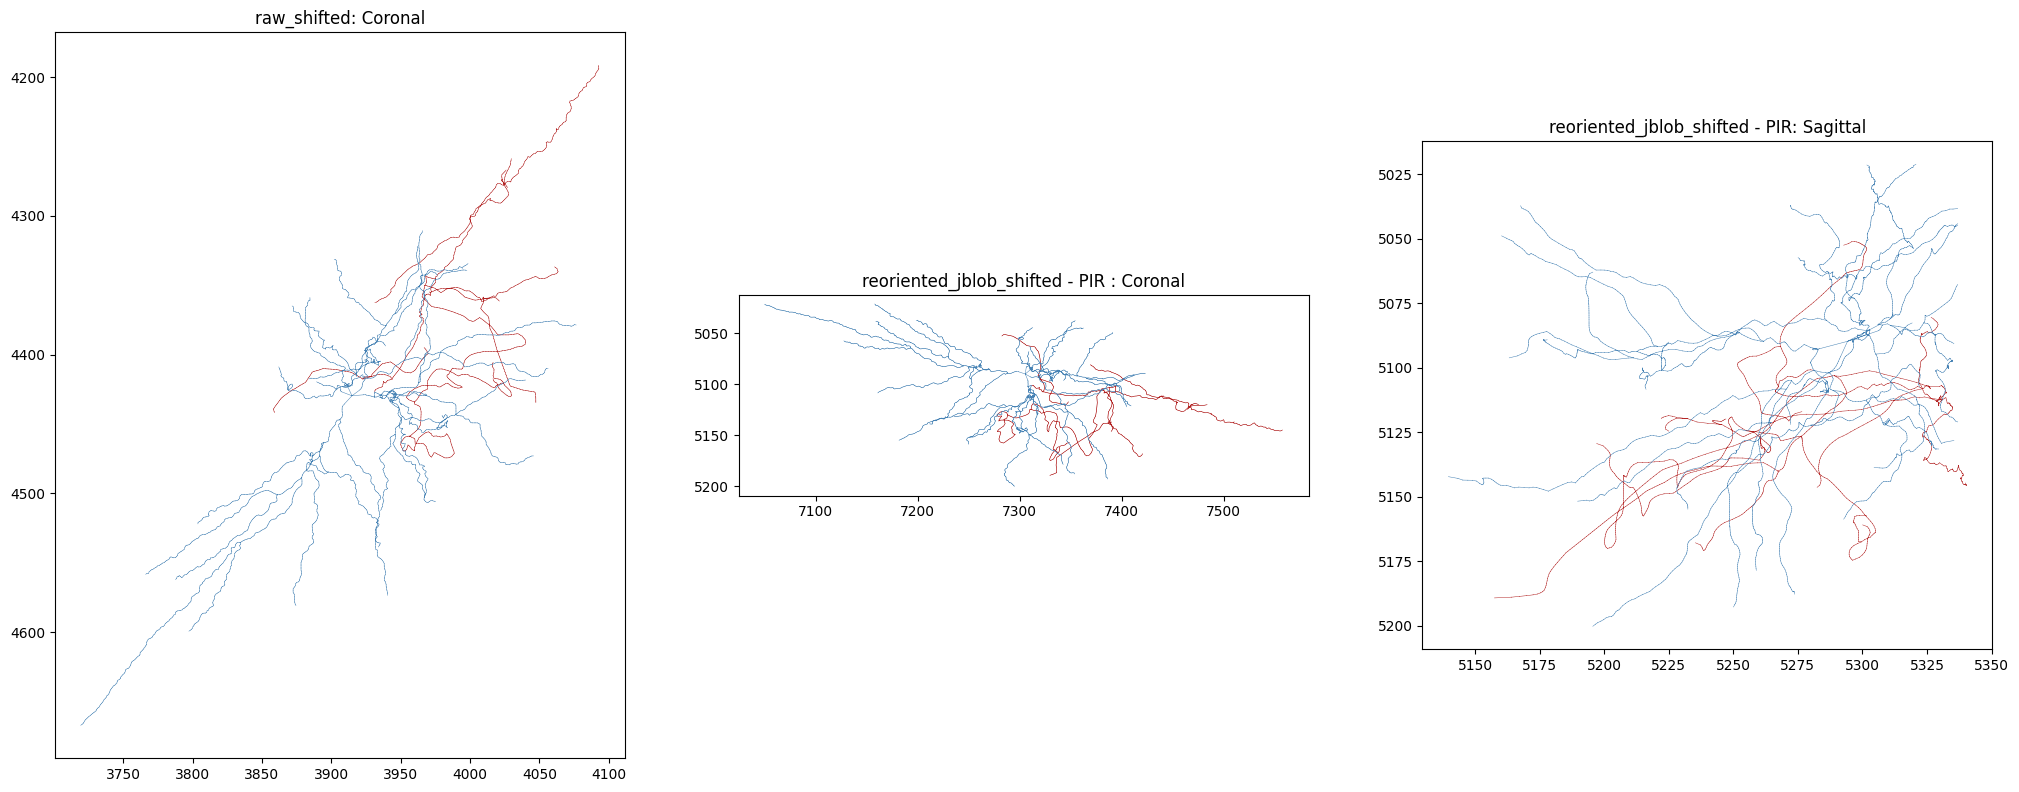

In [159]:
#plot cells that used jblob for soma loc
fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(25,10)) #gridspec_kw = {'wspace':0, 'hspace':0},

nrns = {0: ['raw_shifted: ' + pinning_info['referenceView'], raw_shifted_nrn, False, '', False, True], 
        # 1 : ['reoriented_jblob_shifted - RAS : Coronal', reoriented_shifted_jblob_nrn, 'x', 'z', False, False], 
        # 2 : ['reoriented_jblob_shifted - RAS: Sagittal', reoriented_shifted_jblob_nrn, 'y', 'z', True, False], 
        # 3 : ['reoriented_jblob_shifted - LPS : Coronal', reoriented_shifted_jblob_nrn, 'x', 'z', True, False], 
        # 4 : ['reoriented_jblob_shifted - LPS: Sagittal', reoriented_shifted_jblob_nrn, 'y', 'z', False, False],
        # 5 : ['reoriented_jblob_shifted - LAS : Coronal', reoriented_shifted_jblob_nrn, 'x', 'z', True, False], 
        # 6 : ['reoriented_jblob_shifted - LAS: Sagittal', reoriented_shifted_jblob_nrn, 'y', 'z', True, False],
        1 : ['reoriented_jblob_shifted - PIR : Coronal', reoriented_shifted_jblob_nrn, 'z', 'y', False, True], 
        2 : ['reoriented_jblob_shifted - PIR: Sagittal', reoriented_shifted_jblob_nrn, 'x', 'y', False, True], 
        }
for i, ax in enumerate(axes.reshape(-1)):

    if i < 9:

        nrn = nrns[i][1]
        nrn_type = nrns[i][0]
        x = nrns[i][2]
        y = nrns[i][3]
        invert_x =  nrns[i][4]
        invert_y =  nrns[i][5]
        if i == 0:
            basic_morph_plot_new(nrn, ax, title=nrn_type, side=x )
        else: 
            basic_morph_plot_ccf(nrn, ax, title=nrn_type, x=x, y=y)

        if invert_x: ax.invert_xaxis()
        if invert_y: ax.invert_yaxis()

        ax.set_aspect('equal')

    
plt.show()

In [160]:
def visualize_image_with_morph( image_2d, morph, ax, coords, x, y) :
    
    # visualize a 2D image with morph superimposed

    left = (-0.5) * image_2d.GetSpacing()[0]
    right = (image_2d.GetSize()[0] - 0.5) * image_2d.GetSpacing()[0]
    bottom = (image_2d.GetSize()[1] - 0.5) * image_2d.GetSpacing()[1]
    top =  (- 0.5) * image_2d.GetSpacing()[1]

    slice = sitk.GetArrayViewFromImage(image_2d)
    plt.imshow(slice, extent = (left,right,bottom,top))

    if coords == 'ras':
        basic_morph_plot_ccf(morph, ax=ax, x=x, y=y)
    else:
        basic_morph_plot_new(morph, ax=ax, side=x)


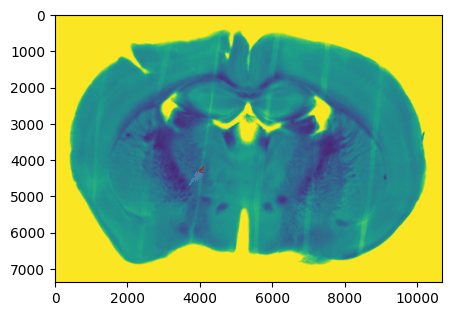

In [161]:
#plot cell on slice
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5)) 
nrn = raw_shifted_nrn
x = False
y = True
visualize_image_with_morph(downsampled_overview, nrn, ax, '', x, y)

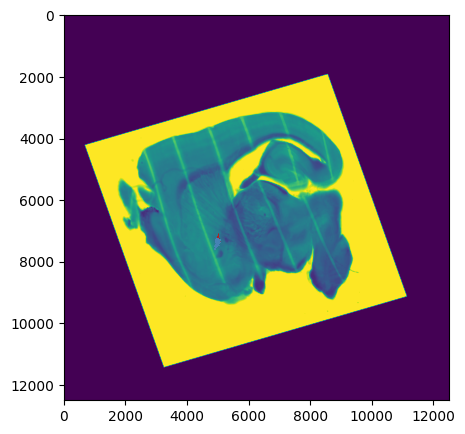

In [146]:
#plot cell on virtual slice
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5)) 
nrn = to_virtual_nrn
x = False
y = True
visualize_image_with_morph(resampled_overview, nrn, ax, 'pir', x, y)

cell_soma_locations table - why don't all cells have entries?

In [62]:
def get_cells_with_ccf_soma_loc(): #how it was in this code. 
    sql = """
    SELECT sp.name AS sp, sm.id, sm.data
    FROM cell_soma_locations csl
    JOIN specimens sp ON csl.specimen_id = sp.id
    JOIN specimen_metadata sm ON sm.specimen_id=sp.id;"""
    
    x = query(sql, ())
    return x

In [62]:
#what are the slice orientations of cells with ccf soma location in the table 
soma_ccf_locs = pd.DataFrame(get_cells_with_ccf_soma_loc())

slice_ids = []
for idx, cell in soma_ccf_locs.iterrows():
    if not cell[0][0] == 'H':
        slice_id = int(cell[0].split('.')[-2])
        slice_ids.append(slice_id)

slice_ids = np.array(slice_ids)
print(np.unique(slice_ids))

[2 6 9]


get 63x image

In [72]:
# def get_63x_img(sp_name):
#     sql = """
#     SELECT slice.id, iser.storage_directory 
#     FROM specimens slice 
#     JOIN image_series iser on iser.specimen_id = slice.id 
#     WHERE slice.name = '{}';""".format(sp_name)

#     x = query(sql, ())[0]

#     sp_id = x[0]
#     sp_dir = x[1]

#     aff_path = os.path.join(sp_dir, 'min_xy_{}.aff'.format(sp_id))

#     # downsample = 0
#     # quality = 100
#     # url = r'{0}?id={1}&'\
#     #                 'downsample={2}&'\
#     #                 'quality={3}'.format(IMAGE_SERVICE_STRING, 
#     #                                     aff_path, downsample, quality)
    

#     return aff_path
    

In [77]:
# aff_path = get_63x_img('Slc32a1-IRES-Cre;Ai14-562359.09.09.01')
# # aff_path = edit_path(aff_path)
# aff_path

'/allen/programs/celltypes/production/mousecelltypes/prod3258/image_series_1096126465/min_xy_1078105907.aff'

In [118]:
# def get_63x_info(sp_name):

# 	sql = """
# 	with imgs63 as (with tag_list as (select distinct ims.id as ims_id, imst.name as tag 
# 									from image_series ims  
# 									join image_series_image_series_tags ims2imst on ims2imst.image_series_id = ims.id  
# 									join image_series_tags imst on imst.id = ims2imst.image_series_tag_id  
# 									order by 1,2), 
# 					max_sti as (select distinct ims.id as ims_id, max(specimen_tissue_index) as pos_in_spec 
# 								from image_series ims  
# 								join sub_images on ims.id = sub_images.image_series_id  
# 								group by ims.id) 
					
# 					select max(id) as image_series_id, max(workflow_state) as workflow_state, specimen_id, max(max_sti.pos_in_spec) as pos_in_spec, array_to_string(array_agg(DISTINCT tag_list.tag), '_AND_') as tags  
# 					from image_series ims  
# 					left join tag_list on tag_list.ims_id = ims.id  
# 					left join max_sti on ims.id = max_sti.ims_id  
# 					where is_stack = true  
# 					group by specimen_id)
# 	select 
# 	imgs63.tags,
# 	imgs63.pos_in_spec,
# 	imgs63.image_series_id as image_series_63x_id,
# 	imgs63.workflow_state as image_series_63x_qc,  
# 	'=HYPERLINK("http://lims2/focal_plane_image_series?id=' || imgs63.image_series_id || '")' as link_63x  
# 	from specimens cell
# 	left join imgs63 on cell.id = imgs63.specimen_id 
# 	where cell.name = '{}';""".format(sp_name)
    
# 	x = query(sql, ())[0]
# 	return x

In [147]:
# info_63 = get_63x_info('Slc32a1-IRES-Cre;Ai14-562359.09.09.01')
# url = info_63[4].split('"')[1]
# url

'http://lims2/focal_plane_image_series?id=1096126465'

In [146]:
# image_path = os.path.join(working_directory, '{}_63x.jpg'.format(specimen_name))
# response = requests.get(url, stream=True)

# with open(image_path, 'wb') as image_file:
#     shutil.copyfileobj(response.raw, image_file)
# del response

given a 63x mip... 


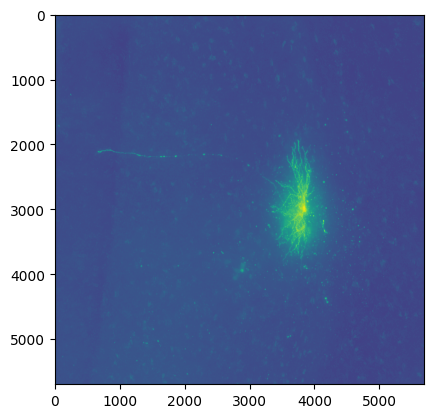

In [89]:
path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\AutotraceReconstruction\1078105907\Byproducts\Single_Tif_Images_Mip.tif'
cell_image = sitk.ReadImage(path, imageIO="TIFFImageIO")
visualize_landmarks( cell_image )


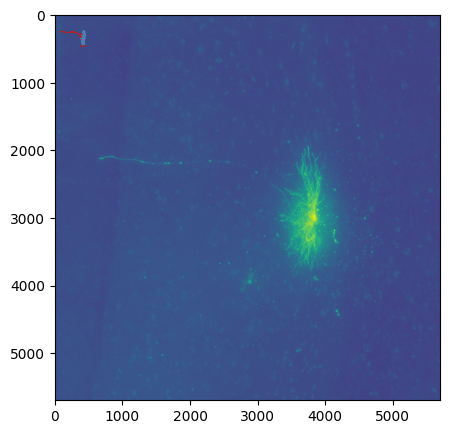

In [91]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5)) 
nrn = raw_nrn
x = False
y = True
visualize_image_with_morph(cell_image, nrn, ax, '', x, y)